# Importing Required Libraries

In [ ]:
# system packages
import os
import warnings

# data and numerical management packages
import math
import pandas as pd
import numpy as np
import sklearn
import json
import random

# (progress bars)
from tqdm import tqdm

# to ignore some irrelevant warnings in evaluation
warnings.filterwarnings('ignore')

In [ ]:
# Mount google drive (for Colab only)
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False
if IN_COLAB:
    from google.colab import drive
    # drive.mount('/content/drive')
    drive.mount('/content/drive',force_remount=True)

# Assignment base directory (Change based on local filesystem)
# base_folder = '/content/drive/MyDrive/University/NLP_Assignments/Assignment_1'
base_folder = '/content/drive/MyDrive/NLP_Assignments/Assignment_1'

#create in and out folders
in_folder = os.path.join(base_folder, "in")
if not os.path.exists(in_folder):
    os.makedirs(in_folder)
out_folder = os.path.join(base_folder, 'out')
if not os.path.exists(out_folder):
    os.makedirs(out_folder)

Mounted at /content/drive


# Data Loading

Here we download the dataset, inspect one of its documents and encode it into a *DataFrame* with the following columns:
1.   *word_id*: word number within a sentence;
2.   *doc*: document number;
3.   *word*: the word itself;
4.   *sentence_id*: sentence number within a document;
5.   *tag*: POS tag associated with the word.



In [ ]:
# Imports for downloading and extracting dataset
from urllib import request
import zipfile

# Folder and path where dataset will be saved
dataset_path = os.path.join(in_folder, "Documents.zip")
print("Dataset path:", dataset_path)

# URL from which to download dataset
url = "https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip"

# Download file from URL
def download_dataset(download_path: str, url: str):
    if not os.path.exists(download_path):
        print("Downloading dataset...")
        request.urlretrieve(url, download_path)
        print("Download complete!")

# Extract dataset given in a zip file
def extract_dataset(download_path: str, extract_path: str):
    if not os.path.exists(os.path.join(in_folder, 'dependency_treebank')):
        print("Extracting dataset... (it may take a while...)")
        with zipfile.ZipFile(download_path, 'r') as loaded_zip:
            loaded_zip.extractall(extract_path)
            loaded_zip.close()
        print("Extraction completed!")

# Execute download
download_dataset(dataset_path, url)

# Execute extraction
extract_dataset(dataset_path, in_folder)

Dataset path: /content/drive/MyDrive/NLP_Assignments/Assignment_1/in/Documents.zip


In [ ]:
# Read a sample document from dataset
dataset_folder = os.path.join(in_folder, 'dependency_treebank')
with open(os.path.join(dataset_folder, 'wsj_0001.dp')) as file:
    print(file.read())

Pierre	NNP	2
Vinken	NNP	8
,	,	2
61	CD	5
years	NNS	6
old	JJ	2
,	,	2
will	MD	0
join	VB	8
the	DT	11
board	NN	9
as	IN	9
a	DT	15
nonexecutive	JJ	15
director	NN	12
Nov.	NNP	9
29	CD	16
.	.	8

Mr.	NNP	2
Vinken	NNP	3
is	VBZ	0
chairman	NN	3
of	IN	4
Elsevier	NNP	7
N.V.	NNP	12
,	,	12
the	DT	12
Dutch	NNP	12
publishing	VBG	12
group	NN	5
.	.	3



In [ ]:
# Display number of documents to user
print("Number of documents:", len(os.listdir(dataset_folder)))

Number of documents: 199


In [ ]:
# Open the dataset documents and store their data into a DataFrame
def encode_dataset() -> pd.DataFrame:
    dataframe_rows = []
    # Get number of documents and their names
    documents_n = len(os.listdir(dataset_folder))
    documents_names = os.listdir(dataset_folder)

    # Loop over documents
    for i in range(documents_n):
        filename = documents_names[i]
        # Open document
        file = open(os.path.join(dataset_folder, filename))
        # Get document index from its filename
        doc_index = int(filename[4:-3])
        # Count sentence id in current document
        sentence_index = 0
        # Count word id in current sentence
        word_index = 0
        # Loop over lines (= words)
        for line in file.readlines():
            # If the line is a newline, then a new sentence begins
            if line == '\n':
                sentence_index += 1
                word_index = 0
            # Otherwise, get the word and other info
            else:
                line = line.split()
                # One row in the dataframe per word, with counters to refer to document, sentence, word order
                dataframe_row = {
                    "word_id": word_index,
                    "doc": doc_index,
                    "word": line[0],
                    "sentence_id": sentence_index,
                    "tag": line[1]
                }
                word_index += 1
                dataframe_rows.append(dataframe_row)
    # Build the dataframe from the words
    df = pd.DataFrame(dataframe_rows)
    return df

# Execute creation of dataset
df = encode_dataset()
df.head()

,word_id,doc,word,sentence_id,tag
0,0,93,It,0,PRP
1,1,93,was,0,VBD
2,2,93,Richard,0,NNP
3,3,93,Nixon,0,NNP
4,4,93,'s,0,POS


# Preprocessing

We apply to the dataset the following preprocessing operations:


1.   Ordering by document, sentence, word numbers;
2.   Removal of the **SYM** tag, since it appears only once in the train set, replaced with an "and" of tag **CC**;
3.   Replacement of words with tags **-LRB-** and **-RRB-** with parentheses symbols, since we are using fixed GloVe embeddings which recognize the latter but not the former;
4.   Lower-casing of the entire text, because case-sensitive GloVe embeddings are only available (to our knowledge) with a dimensionality of 300, which we deem too much for our relatively small dataset.

We also take a look at the tags and their distribution (more on this on the evaluation section).

In [ ]:
# Sort rows by document, then by sentence, then by word
df = df.sort_values(by=['doc', 'sentence_id', 'word_id'])
df.head()

,word_id,doc,word,sentence_id,tag
47771,0,1,Pierre,0,NNP
47772,1,1,Vinken,0,NNP
47773,2,1,",",0,","
47774,3,1,61,0,CD
47775,4,1,years,0,NNS


In [ ]:
# Look at POS tags and the number of their appearances
df.groupby('tag').agg('count')['word_id']

tag
#           16
$          724
''         694
,         4886
-LRB-      120
-RRB-      126
.         3874
:          563
CC        2265
CD        3546
DT        8165
EX          88
FW           4
IN        9857
JJ        5834
JJR        381
JJS        182
LS          13
MD         927
NN       13166
NNP       9410
NNPS       244
NNS       6047
PDT         27
POS        824
PRP       1716
PRP$       766
RB        2822
RBR        136
RBS         35
RP         216
SYM          1
TO        2179
UH           3
VB        2554
VBD       3043
VBG       1460
VBN       2134
VBP       1321
VBZ       2125
WDT        445
WP         241
WP$         14
WRB        178
``         712
Name: word_id, dtype: int64

In [ ]:
# Since "&" symbol appears only once, change it to an "and"
df.loc[df.loc[df['tag'] == "SYM"].index, 'word'] = 'and'
df.loc[df.loc[df['tag'] == "SYM"].index, 'tag'] = 'CC'

In [ ]:
# Save number of unique tags
n_unique_tags = len(df['tag'].unique())
print("Number of unique tags:", n_unique_tags)

Number of unique tags: 44


In [ ]:
# Take a look at some rare/unusual tags
df.loc[df['tag'] == "UH"]

,word_id,doc,word,sentence_id,tag
21745,6,44,OK,9,UH
31432,17,102,no,40,UH
74524,0,118,Oh,85,UH


In [ ]:
df.loc[df['tag'] == "-LRB-"]

,word_id,doc,word,sentence_id,tag
43935,30,20,-LCB-,4,-LRB-
32760,0,22,-LRB-,0,-LRB-
80550,26,27,-LRB-,5,-LRB-
55660,14,37,-LRB-,0,-LRB-
55990,9,37,-LRB-,15,-LRB-
...,...,...,...,...,...
2571,5,186,-LRB-,13,-LRB-
2922,25,186,-LRB-,28,-LRB-
2961,4,186,-LRB-,30,-LRB-
8201,28,187,-LRB-,6,-LRB-


In [ ]:
# Since we will be using pretrained embeddings, it is best to change parenthesis to their more common form
# so that they will not be considered OOV
df.loc[df.loc[df['word'] == "-LRB-"].index, 'word'] = '('
df.loc[df.loc[df['word'] == "-LSB-"].index, 'word'] = '['
df.loc[df.loc[df['word'] == "-LCB-"].index, 'word'] = '{'
df.loc[df.loc[df['word'] == "-RRB-"].index, 'word'] = ')'
df.loc[df.loc[df['word'] == "-RSB-"].index, 'word'] = ']'
df.loc[df.loc[df['word'] == "-RCB-"].index, 'word'] = '}'
df.loc[df['tag'] == "-LRB-"]

,word_id,doc,word,sentence_id,tag
43935,30,20,{,4,-LRB-
32760,0,22,(,0,-LRB-
80550,26,27,(,5,-LRB-
55660,14,37,(,0,-LRB-
55990,9,37,(,15,-LRB-
...,...,...,...,...,...
2571,5,186,(,13,-LRB-
2922,25,186,(,28,-LRB-
2961,4,186,(,30,-LRB-
8201,28,187,(,6,-LRB-


In [ ]:
# Since we are using Glove embeddings which only recognize lowercase words,
# we transform everything to lowercase
df['word'] = df['word'].apply(lambda string: string.lower())

In [ ]:
# saving dataframe for later plotting
df_without_sym = df.copy()

#Tag Encoding

We perform here a simple *DataFrame* processing to transform tag strings into one-hot vectors. We consider this solution simpler and more effective than using integers, as the Neural Network can output a probability distribution rather than a single value. Also, the output values are all between 0 and 1 in this way, making them easier to learn.

In [ ]:
# Import sklearn tools to encode labels
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Define one hot encoding for tags
onehot_transformer = OneHotEncoder(handle_unknown='ignore', sparse = False, dtype = np.int32) # one hot encoder for categorical data
preprocessor = ColumnTransformer(transformers = [('tag_encoder', onehot_transformer, ['tag'])],
                                 remainder = 'passthrough')

# Apply tags encoding
df = preprocessor.fit_transform(df)
df = pd.DataFrame(df)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,pierre,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,vinken,0
2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,",",0
3,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,1,61,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,1,years,0


In [ ]:
# Since all column names have been removed, re-apply the relevant ones
df = df.rename(columns={n_unique_tags: "word_id", n_unique_tags+1: "doc", n_unique_tags+2: "word", n_unique_tags+3:"sentence_id"})
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,word_id,doc,word,sentence_id
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,pierre,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,vinken,0
2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,",",0
3,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,1,61,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,1,years,0


## Train / Validation / Test Split

We perform the split based on the assignment text, and check its correctness.

In [ ]:
# Split dataset based on document ID
df_train = df.loc[df['doc'] <= 100]
df_val = df.loc[(df['doc'] >= 101) & (df['doc'] <= 150)]
df_test = df.loc[df['doc'] >= 151]

# Display validation dataset, as an example
df_val.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,word_id,doc,word,sentence_id
47356,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,101,a,0
47357,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,101,house-senate,0
47358,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,101,conference,0
47359,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,3,101,approved,0
47360,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,101,major,0


# Embeddings

Here we download GloVe embeddings through the gensim API and then define a function to build a new vocabulary or augment an existing one based on a given wordlist. This function ensures that, for instance, an OOV word in the training set is not considered as such anymore in the validation set, since it has been given a (random) embedding during the training vocabulary creation.

In [ ]:
# gensim API to download embeddings
import gensim
import gensim.downloader as gloader

# Download Glove embeddings
def load_embedding_model(embedding_dimension: int = 50):
    # Glove download URL
    download_path = "glove-wiki-gigaword-{}".format(embedding_dimension)
    # Download
    try:
        emb_model = gloader.load(download_path)
    except ValueError as e:
        print("Invalid embedding model name!")
        raise e
    return emb_model

# Set embedding dimension to 50 and download embeddings
embedding_dimension = 50
embedding_model = load_embedding_model(embedding_dimension)

In [ ]:
# Build or augment the current vocabulary given a list of words
def build_vocabulary(glove_model,
                     current_embeddings,
                     current_idx_to_word,
                     embedding_dimension,
                     wordlist):
    # To keep track of the OOV terms
    oov_set = set()
    # If no vocabulary has been built yet...
    if not current_embeddings:
        # Add a non-word for padding
        current_idx_to_word[0] = 0
        current_embeddings[0] = np.zeros(embedding_dimension)
        # Add all words in the provided wordlist
        for word in tqdm(wordlist):
            # If a word has a glove embedding, use it
            try:
                current_embeddings[word] = glove_model[word]
            # Otherwise, generate a random vector with small magnitude
            except KeyError:
                embedding_vector = np.random.uniform(low=-0.05, high=0.05, size=embedding_dimension)
                current_embeddings[word] = embedding_vector
                oov_set.add(word)
            current_idx_to_word[len(current_idx_to_word)] = word
    # If there is already a non-empty vocabulary...
    else:
        # Find which words are new in the wordlist (as in, they don't appear in the current vocabulary)
        old_wordlist = set(current_embeddings.keys())
        new_wordlist = wordlist - old_wordlist
        # Add all new words to the vocabulary
        for word in tqdm(new_wordlist):
            try:
                current_embeddings[word] = glove_model[word]
            except KeyError:
                embedding_vector = np.random.uniform(low=-0.05, high=0.05, size=embedding_dimension)
                current_embeddings[word] = embedding_vector
                oov_set.add(word)
            current_idx_to_word[len(current_idx_to_word)] = word
    return current_embeddings, current_idx_to_word, oov_set

# Vocabulary Creation

We build the three vocabularies (train, val, test), from words directly to their embeddings. The *idx_to_word__* and *word_to_idx__* dictionaries are as such never used, however we have kept them just in case. Alternatively, the *idx_to_word__*  could have been used to first convert words to indices and then use an *Embedding* layer in the model.

In [ ]:
# Create vocabulary for training set
vocab_train, idx_to_word_train, oov_train = build_vocabulary(embedding_model, 
                                                             dict(), 
                                                             dict(), 
                                                             embedding_dimension, 
                                                             set(df_train['word']))
word_to_idx_train = {v: k for k, v in idx_to_word_train.items()}
# Print some stats about the created vocabulary
print("\nNumber of OOV in the train set:", len(oov_train))
print("Number of unique words in the train set:", len(set(df_train['word'])))
print("Ratio: {:.2%}".format(len(oov_train) / len(set(df_train['word']))))

100%|██████████| 7404/7404 [00:00<00:00, 120080.07it/s]


Number of OOV in the train set: 355
Number of unique words in the train set: 7404
Ratio: 4.79%


In [ ]:
# Create vocabulary for validation set
vocab_val, idx_to_word_val, oov_val = build_vocabulary(embedding_model, 
                                                       vocab_train.copy(), 
                                                       idx_to_word_train.copy(), 
                                                       embedding_dimension, 
                                                       set(df_val['word']))
word_to_idx_val = {v: k for k, v in idx_to_word_val.items()}
print("\nNumber of OOV in the val set:", len(oov_val))
print("Number of unique words in the train set:", len(set(df_val['word'])))
print("Ratio: {:.2%}".format(len(oov_val) / len(set(df_val['word']))))

100%|██████████| 2497/2497 [00:00<00:00, 56365.28it/s]



Number of OOV in the val set: 189
Number of unique words in the train set: 5420
Ratio: 3.49%


In [ ]:
# Create vocabulary for test set
vocab_test, idx_to_word_test, oov_test = build_vocabulary(embedding_model, 
                                                          vocab_val.copy(), 
                                                          idx_to_word_val.copy(), 
                                                          embedding_dimension, 
                                                          set(df_test['word']))
word_to_idx_test = {v: k for k, v in idx_to_word_test.items()}
print("\nNumber of OOV in the test set:", len(oov_test))
print("Number of unique words in the test set:", len(set(df_test['word'])))
print("Ratio: {:.2%}".format(len(oov_test) / len(set(df_test['word']))))

100%|██████████| 1046/1046 [00:00<00:00, 39327.36it/s]


Number of OOV in the test set: 128
Number of unique words in the test set: 3407
Ratio: 3.76%


# Input / Output Preparation

Here we define and run a function to produce X and y matrices of inputs and outputs respectively, such that they can be directly feeded to our Neural Network model, which we'll define later. All models take inputs of shape $(batch\_size, max\_seq\_length, n\_dims)$ where $n\_dims$ is the dimension of a word embedding and $max\_seq\_length$ is the longest sentence in the training set. Any sentence in the validation or test set which is longer has been truncated, and smaller sentences have been padded with zeros at their end. The network produces outputs of shape $(batch\_size, max\_seq\_length, n\_tags)$, which are probability distributions over tags in the last dimension.

We run the function for all three datasets, plus an extra input encoding for the most frequent tagger, which we will use as a baseline during evaluation for performance comparison.

In [ ]:
# Print input/output dimensionalities
n_dims = embedding_dimension
n_tags = n_unique_tags
print('Word embedding vector length: ', n_dims,
     '\nTag encoding vector length: ', n_tags)

Word embedding vector length:  50 
Tag encoding vector length:  44


In [ ]:
# Produce input numpy arrays properly formatted to be fed to keras models
def get_Xy(df,
           vocab,
           max_seq_length=0):
    # Separate dataset by sentences
    sentences = [y.set_index('word_id') for x, y in df.groupby(['doc', 'sentence_id'], as_index=False)]
    n_inputs = len(sentences)
    # Get length of all sentences
    sentences_length = [len(s) for s in sentences]
    n_words = sum(sentences_length)
    
    # If no maximum sequence length has been set yet (training set), set it
    if max_seq_length == 0:
        print('Setting maximum sequence length', flush=True)
        max_seq_length = max(sentences_length)
    # Otherwise, truncate longer sentences (if any)
    sentences = [s[:max_seq_length] for s in sentences]
    
    # preparing X and y dimensions
    X = np.zeros((n_inputs, max_seq_length, n_dims), dtype=np.float32)
    y = np.zeros((n_inputs, max_seq_length, n_tags), dtype=np.float32)
    
    # Create X, with words transformed into their embeddings
    for snt_i in tqdm(range(n_inputs)):
        for word_i in range(len(sentences[snt_i])):
            X[snt_i, word_i, :] = vocab[sentences[snt_i]['word'][word_i]]

    # Create y, with one-hot vectors
    for snt_i in tqdm(range(n_inputs)):
        for word_i in range(len(sentences[snt_i])):
            if word_i < len(sentences[snt_i]):
                one_hot_tags = sentences[snt_i].iloc[word_i,0:n_tags].to_numpy(dtype=float)
                y[snt_i, word_i, :] = one_hot_tags
    return X, y, max_seq_length

In [ ]:
# Produce input numpy arrays for training
X_train, y_train, max_seq_length = get_Xy(df_train, vocab_train)

Setting maximum sequence length


100%|██████████| 1963/1963 [00:09<00:00, 217.06it/s]


In [ ]:
# Produce input numpy arrays for validation
X_val, y_val, _ = get_Xy(df_val, vocab_val, max_seq_length)

100%|██████████| 1299/1299 [00:06<00:00, 199.35it/s]


In [ ]:
# Produce input numpy arrays for testing
X_test, y_test, _ = get_Xy(df_test, vocab_test, max_seq_length)

100%|██████████| 652/652 [00:03<00:00, 211.27it/s]


In [ ]:
# Print input/output dimensions
print('Train input shape:\t\t', X_train.shape,
      '\nTrain output shape:\t\t', y_train.shape,
      '\nValidation input shape:\t\t', X_val.shape,
      '\nValidation output shape:\t', y_val.shape,
      '\nTest input shape:\t\t', X_test.shape,
      '\nTest output shape:\t\t', y_test.shape)

Train input shape:		 (1963, 249, 50) 
Train output shape:		 (1963, 249, 44) 
Validation input shape:		 (1299, 249, 50) 
Validation output shape:	 (1299, 249, 44) 
Test input shape:		 (652, 249, 50) 
Test output shape:		 (652, 249, 44)


In [ ]:
# create X_test_mfc for most frequent class tagger
sentences = [y.set_index('word_id') for x, y in df_test.groupby(['doc', 'sentence_id'], as_index=False)]
n_inputs = len(sentences)
sentences = [s[:max_seq_length] for s in sentences]
X_test_mfc = []
# since we do not need embedded words for mfc tagger, we create vectors of strings
# and we pad as usual
for snt_i in tqdm(range(n_inputs)):
    sentence_len = len(sentences[snt_i])
    for word in sentences[snt_i]['word']:
        X_test_mfc.append(word)
    for _ in range(max_seq_length-sentence_len):
        X_test_mfc.append(0)
        
assert  (X_test.shape[0], X_test.shape[1]) == (n_inputs, max_seq_length)
X_test_mfc = np.array(X_test_mfc).reshape((n_inputs, max_seq_length))

100%|██████████| 652/652 [00:00<00:00, 7596.27it/s]


# Model Parameter Setting

In [ ]:
# Import keras/tensorflow libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras import callbacks

First we create a list with all combinations of hyper-parameters that we want to try out. We also store the metrics we want to keep track of during training (accuracy).

In [ ]:
# Dict of parameters to test for the model
param_grid = dict([
    ('nn_type', ['Base', 'GRU_Var', 'LSTM_Var', 'Dense_Var']),
    ('nodes', [8, 32, 64, 128]),
    ('activation', ['softmax']),
    ('loss', ['categorical_crossentropy']),
    ('lr', [0.1, 0.01, 0.001]),
    ('regularizer_weight', [0, 1e-3, 1e-4, 1e-5])
])

# List of metrics used for validation
experiment_metrics = ['categorical_accuracy']

In [ ]:
# Produce list of possible parameters combinations from the dictionary
def get_params_list(param_grid):
    params = [{}]
    for new_par_name, new_par_list in param_grid.items():
        par_update = []
        for new_par in new_par_list:
            for old_par_dict in params:
                par_update.append(dict(old_par_dict))
                par_update[-1][new_par_name] = new_par
        params = par_update
    return params

params = get_params_list(param_grid)

The function *create_model* instantiates a keras model and compiles it, with a structure defined as follows:

($i$) A non-trainable Masking layer, so that zero embeddings are effectively ignored;

($ii$) A Bidirectional Recurrent layer, such as LSTM or GRU; 

($iii$) (Optionally) an additional LSTM or dense layer;

($iv$) A final dense layer with softmax activation.

In [ ]:
# Create a keras model, based on parameters
def create_model(nn_type,
                 nodes,
                 activation,
                 loss,
                 lr,
                 regularizer_weight,
                 metrics):
    # Input is an embedded sentence
    inputs = keras.Input(shape=(max_seq_length, n_dims))
    # Masking layer for padded words (necessary to improve results since variance of sentence length
    # is very high)
    x = layers.Masking(mask_value=0.,
                       input_shape=(max_seq_length, n_dims))(inputs)
    # Add layers as per the assignment requirements
    if nn_type=='Base':
        x = layers.Bidirectional(layers.LSTM(nodes, 
                                             return_sequences=True, 
                                             kernel_regularizer=regularizers.l2(regularizer_weight),
                                             bias_regularizer=regularizers.l2(regularizer_weight),
                                             recurrent_regularizer=regularizers.l2(regularizer_weight)))(x)
    elif nn_type=='GRU_Var':
        x = layers.Bidirectional(layers.GRU(nodes, 
                                            return_sequences=True, 
                                            kernel_regularizer=regularizers.l2(regularizer_weight),
                                            bias_regularizer=regularizers.l2(regularizer_weight),
                                            recurrent_regularizer=regularizers.l2(regularizer_weight)))(x)
    elif nn_type=='LSTM_Var':
        x = layers.Bidirectional(layers.LSTM(nodes, 
                                             return_sequences=True, 
                                             kernel_regularizer=regularizers.l2(regularizer_weight),
                                             bias_regularizer=regularizers.l2(regularizer_weight),
                                             recurrent_regularizer=regularizers.l2(regularizer_weight)))(x)
        x = layers.Bidirectional(layers.LSTM(nodes, 
                                             return_sequences=True, 
                                             kernel_regularizer=regularizers.l2(regularizer_weight),
                                             bias_regularizer=regularizers.l2(regularizer_weight),
                                             recurrent_regularizer=regularizers.l2(regularizer_weight)))(x)
    elif nn_type=='Dense_Var':
        x = layers.Bidirectional(layers.LSTM(nodes, 
                                             return_sequences=True, 
                                             kernel_regularizer=regularizers.l2(regularizer_weight),
                                             bias_regularizer=regularizers.l2(regularizer_weight),
                                             recurrent_regularizer=regularizers.l2(regularizer_weight)))(x)
        x = layers.Dense(nodes, activation=activation, 
                         kernel_regularizer=regularizers.l2(regularizer_weight), 
                         bias_regularizer=regularizers.l2(regularizer_weight))(x)
    # Final layer is FC, with a 'softmax' activation to produce a probability distribution over all POS tags
    out = layers.Dense(n_tags, activation='softmax')(x)

    # Create and compile model
    model = keras.Model(inputs, out)
    model.compile(loss=loss, optimizer=keras.optimizers.Adam(learning_rate=lr), metrics=metrics)
    return model

The *post_processing* function takes in input the predicted $\hat y$ and the true $y$ (which are one-hot encoded vectors), removes outputs which are padding, converts the two encoded $y$ into integers and also gets the indices of POS tags which appear in the true $y$ which are non-punctuation/symbols. In this way, we do not consider those classes when computing metrics.

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

def post_processing(y_true, y_pred):
    # Reshape into 2D arrays of (words * sentences, tags)
    y_pred_fl = y_pred.reshape((y_pred.shape[0] * y_pred.shape[1], y_pred.shape[2]))
    y_true_fl =  y_true.reshape((y_true.shape[0] *  y_true.shape[1],  y_true.shape[2]))

    # Create a boolean mask for padded words
    mask = ~(y_true_fl == 0).all(axis=-1)
    # Remove masked words from labels
    y_pred_fl = y_pred_fl[mask]
    y_true_fl = y_true_fl[mask]

    # Get highest-rated POS tag for each word
    y_pred_index = np.argmax(y_pred_fl, axis=-1)
    y_true_index = np.argmax(y_true_fl, axis=-1)
    # Hard-coded list of non-punctuation/symbol classes
    no_punct_symbols_classes = [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 
                                26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42]

    # Get indices of POS tags which are non-punctuation/symbols and also appear among the true tags (necessary for sklearn to work properly)
    true_class_labels = list(set(no_punct_symbols_classes).intersection(np.unique(y_true_index)))
    # Weigh a word zero if it doesn't have a tag among the ones in the previous line (necessary for sklearn to work properly)
    sample_weights = np.vectorize(lambda x: 1 if x in true_class_labels else 0)(y_true_index)

    return y_true_index, y_pred_index, true_class_labels, sample_weights

The *compute_metrics* function simply computes accuracy and F1-macro scores masked by non-punctuation/symbol classes.

In [ ]:
# Function to compute sklearn metrics based on model predictions
def compute_metrics(y_true, y_pred):
    y_true_index, y_pred_index, true_class_labels, sample_weights = post_processing(y_true, y_pred)

    # Compute accuracy and F1-macro
    model_metrics = {
    'accuracy': accuracy_score(y_true_index, y_pred_index, sample_weight=sample_weights),
    'f1': f1_score(y_true_index, y_pred_index, average='macro', labels=true_class_labels),
    }
    return model_metrics

The *all_models_fit* function brings all previous functions together to run all possible models and store their performances.

In [ ]:
# Create and fit all models based on parameter grid, store metrics of each into a history
def all_models_fit(params, X_train, y_train, X_val, y_val, metrics, N_test=1):
    # History of all models
    history_dict = {}
    # Regularization: early stopping based on accuracy
    earlystop_callback = callbacks.EarlyStopping(
        monitor="val_categorical_accuracy",
        min_delta=0,
        patience=2,
        verbose=0,
        mode="max",
        baseline=None,
        restore_best_weights=True,
    )
    # For each parameter combination...
    for i in tqdm(range(len(params))):
        # Create model
        model = create_model(*params[i].values(), metrics=metrics)
        
        # Init history for current model
        history_dict[i] = {
            'training accuracy': [],
            'training loss': [],
            'validation accuracy': [],
            'validation loss': [],
            'masked validation accuracy': [],
            'masked validation f1': []}

        # Fit N_test times to get more statistics on each set of parameters
        for n in range(N_test):
            history = model.fit(X_train, y_train,
                                validation_data = (X_val, y_val),
                                epochs= 15,
                                verbose = 0, callbacks=[earlystop_callback])
            
            # Store final accuracy of each fit, computed by keras
            history_dict[i]['training accuracy'].append(history.history['categorical_accuracy'][-1])
            history_dict[i]['training loss'].append(history.history['loss'][-1])
            history_dict[i]['validation accuracy'].append(history.history['val_categorical_accuracy'][-1])
            history_dict[i]['validation loss'].append(history.history['val_loss'][-1]) 
            
            # Store (masked) accuracy and F1-macro for last epoch, computed by sklearn
            val_metrics = compute_metrics(y_val, model.predict(X_val))
            history_dict[i]['masked validation accuracy'].append(val_metrics['accuracy'])
            history_dict[i]['masked validation f1'].append(val_metrics['f1']) 
    return history_dict

# Model Creation and Fitting
*May take quite some time to execute!*

(Note that the *training_history* is already given as a text file: you can skip to "most frequent class tagger fit")

In [ ]:
# Can be useful to speed up training
#physical_devices = tf.config.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [ ]:
# Fit all models and store their performances
train_history = all_models_fit(params, X_train, y_train, X_val, y_val, experiment_metrics, N_test=15)

100%|█████████████████████████████████████████████████████████████████████████████| 192/192 [6:53:52<00:00, 129.33s/it]


In [ ]:
# Save history as a JSON file
filename = 'training_history.json'

output_string = json.dumps({'params': params, 'history': list(train_history.values())})
with open(os.path.join(out_folder, filename), 'w') as file:
    file.write(output_string)

Here we instantiate as a baseline a most frequent class tagger, based on the training set, via a simple look-up table.

In [ ]:
# most frequent class tagger fit
mfc_table = {}

# the tags are one hot encoded vectors
# => sum each 'coordinate' of those vectors
# => the argmax will give the most frequent tag

# for each line of train dataframe...
for line in tqdm(range(len(df_train))):
    # check the word
    word = df_train.loc[line]['word']
    # and sum the encoded tag vectors
    mfc_table[word] = mfc_table.get(word, np.zeros((n_tags,))) + df_train.loc[line][:n_tags].to_numpy()

# save only argmax => the tag index
for word in tqdm(mfc_table):
    tag_idx = np.argmax(mfc_table[word])
    new_tag = np.zeros((n_tags,))
    new_tag[tag_idx] = 1
    mfc_table[word] = new_tag

100%|██████████| 7404/7404 [00:00<00:00, 165569.93it/s]


# Evaluation of Best Models

In [ ]:
# Load history as a JSON file
filename = 'training_history.json'

with open(os.path.join(out_folder, filename), 'r') as file:
    json_string = file.read()

train_params = json.loads(json_string)['params']
train_history = json.loads(json_string)['history']

In [ ]:
# check if there is any nan loss
loss_list = [hist['training loss'][test] for hist in train_history for test in range(len(hist['training loss']))]
print("Are there NaN losses?:", any([math.isnan(l) for l in loss_list]))

Are there NaN losses?: False


Since we have done $N_{test}$ measurements of F1 and accuracy on each model, we can use the mean ± the standard deviation for the measure for a specific model.

In [ ]:
# Get f1 scores for each model
val_f1_scores = [hist['masked validation f1'] for hist in train_history]
val_f1_scores_mean = [np.mean(v) for v in val_f1_scores]
val_f1_scores_std = [np.std(v) for v in val_f1_scores]

# Get accuracy scores for each model
val_acc_scores = [hist['masked validation accuracy'] for hist in train_history]
val_acc_scores_mean = [np.mean(v) for v in val_acc_scores]
val_acc_scores_std = [np.std(v) for v in val_acc_scores]

Here we fetch the two best models and their parameter combinations. Note the scores are only an approximation, as the models have not been run for enough epochs (due to time constraints), and final model results will be significantly better.

In [ ]:
# Get best model parameters
# Best model chosen according to f1 score
best_model_index = np.argmax(val_f1_scores_mean)
best_params = train_params[best_model_index]
best_f1_score = val_f1_scores_mean[best_model_index]
best_f1_std = val_f1_scores_std[best_model_index]
best_acc_score = val_acc_scores_mean[best_model_index]
best_acc_std = val_acc_scores_std[best_model_index]
print("### Best Model")
print('F1 score:\t{:.3f} ± {:.3f}'.format(best_f1_score, 2*best_f1_std))
print('Accuracy score:\t{:.3f} ± {:.3f}'.format(best_acc_score, 2*best_acc_std))
print(best_params)

# Get second best model parameters
# Second best model chosen according to f1 score
second_best_model_index = np.argsort(val_f1_scores_mean)[-2]
second_best_params = train_params[second_best_model_index]
second_best_f1_score = val_f1_scores_mean[second_best_model_index]
second_best_f1_std = val_f1_scores_std[second_best_model_index]
second_best_acc_score = val_acc_scores_mean[second_best_model_index]
second_best_acc_std = val_acc_scores_std[second_best_model_index]
print("\n### Second Best Model")
print('F1 score:\t{:.3f} ± {:.3f}'.format(second_best_f1_score, 2*second_best_f1_std))
print('Accuracy score:\t{:.3f} ± {:.3f}'.format(second_best_acc_score, 2*second_best_acc_std))
print(second_best_params)

### Best Model
F1 score:	0.780 ± 0.009
Accuracy score:	0.890 ± 0.002
{'nn_type': 'LSTM_Var', 'nodes': 64, 'activation': 'softmax', 'loss': 'categorical_crossentropy', 'lr': 0.01, 'regularizer_weight': 0}

### Second Best Model
F1 score:	0.776 ± 0.023
Accuracy score:	0.876 ± 0.004
{'nn_type': 'Base', 'nodes': 64, 'activation': 'softmax', 'loss': 'categorical_crossentropy', 'lr': 0.01, 'regularizer_weight': 1e-05}


In [ ]:
# Regularization: early stopping based on accuracy
earlystop_callback = callbacks.EarlyStopping(
    monitor="val_categorical_accuracy",
    min_delta=0,
    patience=5,
    verbose=0,
    mode="max",
    baseline=None,
    restore_best_weights=True,
)

*May take quite some time to execute!*

Fit the two best models with a larger number of epochs.

(Note that both the models and their training history are given: you can skip to "Load the two best models and their history")

In [ ]:
# Fit the best model with a larger number of epochs
best_model = create_model(*best_params.values(), metrics=experiment_metrics)
best_model_hist = best_model.fit(X_train, y_train, 
                                 validation_data=(X_val, y_val),
                                 epochs= 30,
                                 verbose = 1,
                                 callbacks=[earlystop_callback]).history

Epoch 1/30
62/62 [==============================] - 15s 85ms/step - loss: 0.1740 - categorical_accuracy: 0.4986 - val_loss: 0.0852 - val_categorical_accuracy: 0.7377
Epoch 2/30
62/62 [==============================] - 2s 30ms/step - loss: 0.0596 - categorical_accuracy: 0.8207 - val_loss: 0.0553 - val_categorical_accuracy: 0.8258
Epoch 3/30
62/62 [==============================] - 2s 30ms/step - loss: 0.0386 - categorical_accuracy: 0.8824 - val_loss: 0.0415 - val_categorical_accuracy: 0.8718
Epoch 4/30
62/62 [==============================] - 2s 30ms/step - loss: 0.0277 - categorical_accuracy: 0.9165 - val_loss: 0.0383 - val_categorical_accuracy: 0.8812
Epoch 5/30
62/62 [==============================] - 2s 30ms/step - loss: 0.0207 - categorical_accuracy: 0.9369 - val_loss: 0.0350 - val_categorical_accuracy: 0.8918
Epoch 6/30
62/62 [==============================] - 2s 29ms/step - loss: 0.0154 - categorical_accuracy: 0.9535 - val_loss: 0.0359 - val_categorical_accuracy: 0.8931
Epoch 7/3

In [ ]:
# Fit the second best model with a larger number of epochs
second_best_model = create_model(*second_best_params.values(), metrics=experiment_metrics)
second_model_hist = second_best_model.fit(X_train, y_train,
                                          validation_data=(X_val, y_val),
                                          epochs= 30,
                                          verbose = 1,
                                          callbacks=[earlystop_callback]).history

Epoch 1/30
62/62 [==============================] - 7s 44ms/step - loss: 0.1481 - categorical_accuracy: 0.6136 - val_loss: 0.0836 - val_categorical_accuracy: 0.7789
Epoch 2/30
62/62 [==============================] - 1s 18ms/step - loss: 0.0677 - categorical_accuracy: 0.8248 - val_loss: 0.0648 - val_categorical_accuracy: 0.8272
Epoch 3/30
62/62 [==============================] - 1s 18ms/step - loss: 0.0535 - categorical_accuracy: 0.8676 - val_loss: 0.0567 - val_categorical_accuracy: 0.8554
Epoch 4/30
62/62 [==============================] - 1s 18ms/step - loss: 0.0463 - categorical_accuracy: 0.8902 - val_loss: 0.0556 - val_categorical_accuracy: 0.8559
Epoch 5/30
62/62 [==============================] - 1s 18ms/step - loss: 0.0426 - categorical_accuracy: 0.9024 - val_loss: 0.0509 - val_categorical_accuracy: 0.8728
Epoch 6/30
62/62 [==============================] - 1s 18ms/step - loss: 0.0389 - categorical_accuracy: 0.9143 - val_loss: 0.0489 - val_categorical_accuracy: 0.8785
Epoch 7/30

Save the two best models and their history.

In [ ]:
# Save best model using Keras API
best_model_folder = os.path.join(out_folder, 'best_model')

# Save best model's history
best_model.save(best_model_folder)

filename = 'training_history.json'
output_string = json.dumps({'params': best_params, 'history': best_model_hist})
with open(os.path.join(best_model_folder, filename), 'w') as file:
    file.write(output_string)

INFO:tensorflow:Assets written to: out\best_model\assets


INFO:tensorflow:Assets written to: out\best_model\assets


In [ ]:
# Save second best model using Keras API
second_model_folder = os.path.join(out_folder, 'second_best_model')

second_best_model.save(second_model_folder)

# Save second best model's history
filename = 'training_history.json'
output_string = json.dumps({'params': second_best_params, 'history': second_model_hist})
with open(os.path.join(second_model_folder, filename), 'w') as file:
    file.write(output_string)

INFO:tensorflow:Assets written to: out\second_best_model\assets


INFO:tensorflow:Assets written to: out\second_best_model\assets


Load the two best models and their history.

In [ ]:
# Load best model using Keras API
best_model_folder = os.path.join(out_folder, 'best_model')

best_model = keras.models.load_model(best_model_folder)

# Load best model's history
filename = 'training_history.json'
with open(os.path.join(best_model_folder, filename), 'r') as file:
    json_string = file.read()
best_train_params = json.loads(json_string)['params']
best_train_history = json.loads(json_string)['history']

In [ ]:
# Load second best model using Keras API
second_model_folder = os.path.join(out_folder, 'second_best_model')

second_best_model = keras.models.load_model(second_model_folder)

# Load second best model's history
filename = 'training_history.json'
with open(os.path.join(second_model_folder, filename), 'r') as file:
    json_string = file.read()
second_train_params = json.loads(json_string)['params']
second_train_history = json.loads(json_string)['history']

Print evaluation metrics of the two best models and of the baseline mfc.

In [ ]:
# Compute and print metrics for best model
best_model_metrics = compute_metrics(y_test, best_model.predict(X_test))
print(best_model_metrics)

{'accuracy': 0.903041825095057, 'f1': 0.8153080909399386}


In [ ]:
# Compute and print metrics for the second best model
second_best_model_metrics = compute_metrics(y_test, second_best_model.predict(X_test))
print(second_best_model_metrics)

{'accuracy': 0.8904650482597251, 'f1': 0.8044833014177488}


In [ ]:
# evaluate mfc
y_shape = y_test.shape
y_pred_mfc = np.zeros(y_shape, dtype=np.float32)
for sentence_idx in tqdm(range(len(X_test_mfc))):
    for word_idx in range(len(X_test_mfc[sentence_idx])):
        # for each word of the test set simply get the tag from mfc_table[word]
        # if word not in mfc_table => chose random
        word = X_test_mfc[sentence_idx, word_idx]
        y_pred_mfc[sentence_idx, word_idx, :] = mfc_table.get(word, random.choice(list(mfc_table.values())))
        
mfc_model_metrics = compute_metrics(y_test, y_pred_mfc)
print('\n', mfc_model_metrics)

100%|██████████| 652/652 [00:16<00:00, 38.41it/s]



 {'accuracy': 0.8012576776835332, 'f1': 0.7329749874144518}


# Plots

In [ ]:
# API for plots
from matplotlib import pyplot as plt
%matplotlib inline

Plotting count of tags in the entire dataset: we immediately notice a high disparity in values.

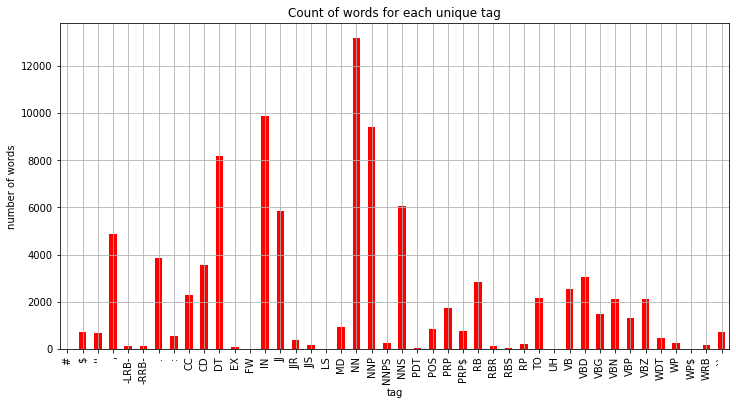

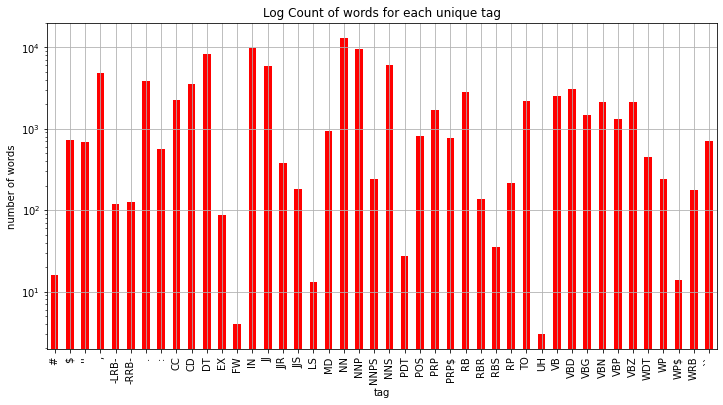

In [ ]:
# plot how many words we have in the dataset for every single tag 
fig = plt.figure(figsize=(12, 6))
df_without_sym.groupby('tag')                                                \
              .agg('count')['word_id']                                       \
              .plot.bar(color='r', title="Count of words for each unique tag", 
                        grid=True, ylabel="number of words")
              
fig = plt.figure(figsize=(12, 6))  
df_without_sym.groupby('tag')                                                \
              .agg('count')['word_id']                                       \
              .plot.bar(color='r', title="Log Count of words for each unique tag", 
                        grid=True, ylabel="number of words", logy=True)


We can also notice how punctuation tags have quite high frequency, which is why it is an important choice whether to consider them or not for performance evaluation.

-----

The length of sentences is another important information because it influences the input dimension of our model, which must be fixed. As a consequence shorter sentences must be filled up with padding and longer ones should be truncated.

In [ ]:
# plots an histogram of the length of each sentence in the dataset
def plot_LenSentences_hist(df, logy=True, figsize=(12,6)):
    fig = plt.figure(figsize=figsize)
    plt.ylabel('log len sentences')
    plt.xlabel('id sentence')
    plt.title('Sentences length', fontweight="bold")
    ax = fig.add_subplot(1, 1, 1)
    
    # Separate dataset by sentences
    sentences = [y.set_index('word_id') for x, y in df.groupby(['doc', 'sentence_id'], as_index=False)]
    n_inputs = len(sentences)
    # Get length of all sentences
    sentences_length = [len(s) for s in sentences]
    n_words = sum(sentences_length)
    ax.hist(sentences_length, bins=len(sentences_length), log=logy)
    plt.show()

In [ ]:
sentences = [y.set_index('word_id') for x, y in df_without_sym.groupby(['doc', 'sentence_id'], as_index=False)]
sentences_length = [len(s) for s in sentences]
print('Average sentence length: {:.0f}'.format(np.mean(sentences_length)))

Average sentence length: 24


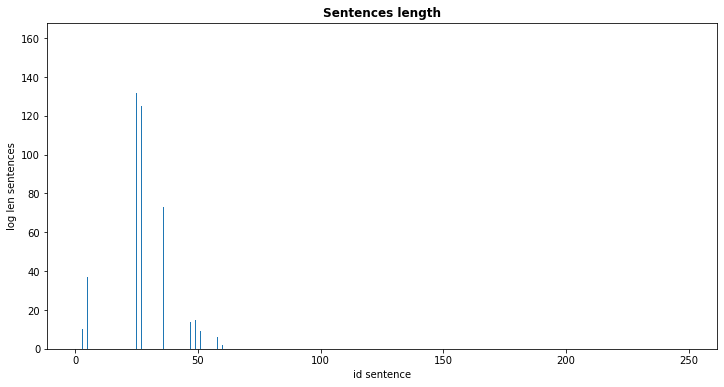

In [ ]:
plot_LenSentences_hist(df_without_sym, logy=False)

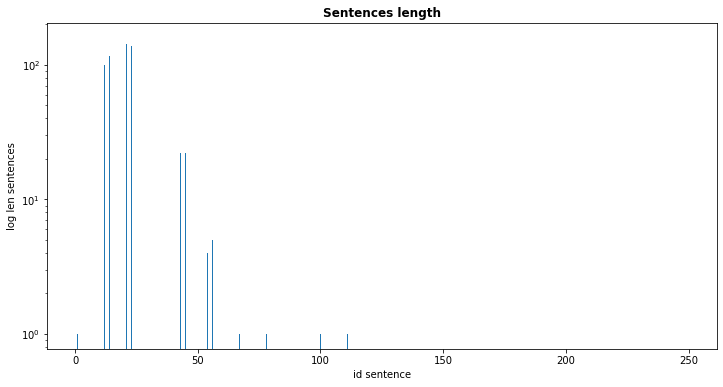

In [ ]:
plot_LenSentences_hist(df_without_sym, logy=True)

We notice from the two histograms (the second represents the same data of the first in log scale) a Poisson distribution with a mean value around 24 and a long low tail, due to a few long sentences. The high length of those sentences is due to them containing very long bulleted lists of elements.

-----

The next plots give a visual representation of the sentences we have in train, validation and test set. Since we take the maximum sentence length of the training set as input dimension of our models, and since most sentences are much shorter, as we have seen from the previous plots, the result is a massive use of padding. In the following plots each column represents a sentence: the colored part are word embeddings (first channel), while the white part represents the padding. Choosing this approach, the usage of an initial masking layer becomes essential: without masking we were obtaining values of accuracy below 10%, due to the high influence of padding.

In [ ]:
# plots what is contained inside the dataframe after the embedding.
def plot_dataframe(data, labels=None, vmin=-1.96, vmax=1.96,
        figsize=(9, 3), autoclose=True, s=4, title=None, 
        xlabel=None, ylabel=None):
    if autoclose: plt.close('all')
    plt.figure(figsize=figsize)
    if title is not None:
        plt.title(title, fontweight="bold")
    if xlabel is not None:
        plt.xlabel(xlabel)
    if ylabel is not None:
        plt.ylabel(ylabel)
    plt.imshow(data.T.iloc[:, :], aspect='auto',
            cmap='RdBu', vmin=vmin, vmax=vmax)
    if labels is not None:
        # nonzero = data.index[labels != 0]
        ncol = len(data.columns)
        lvl = - 0.05 * ncol
        # plt.scatter(nonzero, lvl*np.ones(len(nonzero)),
        #         s=s, color='tab:orange')
        plt.scatter(labels.index, np.ones(len(labels)) * lvl,
                s=s,
                color=plt.get_cmap('tab10')(labels))
    plt.tight_layout() 

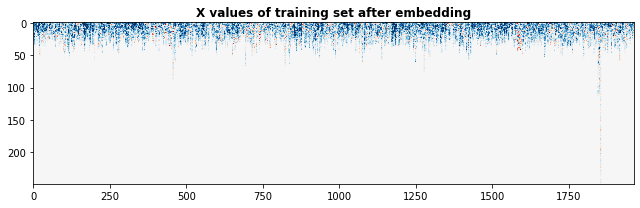

In [ ]:
plot_dataframe(pd.DataFrame(X_train[:,:,0]), vmin=-0.5, vmax=0.5,
               title="X values of training set after embedding")

Towards the right we can see the longest sentence, the one determining the shape of our input (the only column colored untill the bottom).

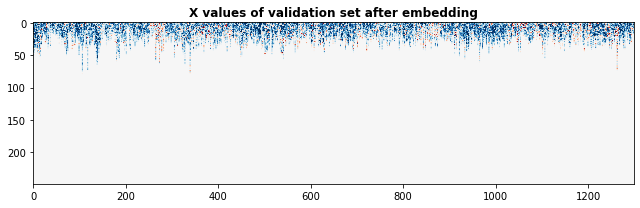

In [ ]:
plot_dataframe(pd.DataFrame(X_val[:,:,0]), vmin=-0.5, vmax=0.5,
               title="X values of validation set after embedding")

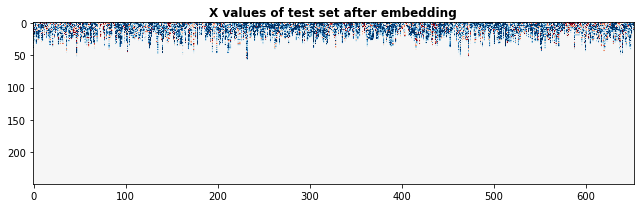

In [ ]:
plot_dataframe(pd.DataFrame(X_test[:,:,0]), vmin=-0.5, vmax=0.5,
               title="X values of test set after embedding")

These plots show also our choice to set the sentence at the beginning of the input and the padding at the bottom. Other choices may be to set the sentence in the middle or at the bottom, but since we use masking they are not meaningful anyway.

-----

In [ ]:
# Saving in a dataframe all informations from the training history
res_config = []
for i in range(len(params)):
    config = []
    config.append(params[i]['nn_type'])
    config.append(params[i]['nodes'])
    config.append(params[i]['activation'])
    config.append(params[i]['loss'])
    config.append(params[i]['lr'])
    config.append(params[i]['regularizer_weight'])
    config.append(np.mean(train_history[i]['training accuracy']))
    config.append(np.std(train_history[i]['training accuracy']))
    config.append(np.mean(train_history[i]['validation accuracy']))
    config.append(np.std(train_history[i]['validation accuracy']))
    config.append(np.mean(train_history[i]['training loss']))
    config.append(np.std(train_history[i]['training loss']))
    config.append(np.mean(train_history[i]['validation loss']))
    config.append(np.std(train_history[i]['validation loss']))
    config.append(np.mean(train_history[i]['masked validation accuracy']))
    config.append(np.std(train_history[i]['masked validation accuracy']))
    config.append(np.mean(train_history[i]['masked validation f1']))
    config.append(np.std(train_history[i]['masked validation f1']))
    res_config.append(config)

df_res_config = pd.DataFrame(np.array(res_config), 
        columns=["nn_type", "nodes", "activation", "loss", "lr", "regularizer_weight",
                 "training accuracy", "training accuracy std", 
                 "validation accuracy", "validation accuracy std",
                 "training loss", "training loss std",
                 "validation loss", "validation loss std",
                 "masked validation accuracy", "masked validation accuracy std",
                 "masked validation f1", "masked validation f1 std"])

In [ ]:
# Ensure to have correct data type
numeric_columns = ["nodes", "lr", "regularizer_weight",
                   "training accuracy", "training accuracy std", 
                   "validation accuracy", "validation accuracy std",
                   "training loss", "training loss std",
                   "validation loss", "validation loss std",
                   "masked validation accuracy", "masked validation accuracy std",
                   "masked validation f1", "masked validation f1 std"]
df_res_config[numeric_columns] = df_res_config[numeric_columns].apply(pd.to_numeric)

The following function plots a specific metric for all tested architectures, highlighting with a vertical line the two best models. In the $y$ axis we have the selected metric, while in the $x$ axis we have the model index, corresponding to a specific set of parameter values (the map between the model index and the set of parameter values is done with "train_params"). 

The line connecting the points of the same architecture do not have any meaning or imply any order relation between those models, they are kept only to make the plot more readable.

From this plot we can check if the two best models are just lucky guesses (the set of parameter values give positive result only for a specific architecture) or if they are due to a positive trend involving in the choice of hyper-parameters for similar models. We can also check the variance of that model to figure out if the measure is reliable (low variance) or not (high variance) thanks to the errorbars.

In [ ]:
# plot specified metric for all tested models
def plot_across_models(df, nn_types, fbm=None, sbm=None, legend_pos='lower left',
                       figsize=(12,6), metric='training accuracy'):
    plt.figure(figsize=figsize)
    
    # assuming standard error (SE)
    # mean +/- 1*std => 68.2% of vals
    # mean +/- 2*std => 95.4% of vals
    # mean +/- 3*std => 99.6% of vals
    std_mult = 2
    colors = ['red', 'blue', 'green', 'purple']
    
    # error bars
    for idx in range(len(nn_types)):
        plt.errorbar(x = df.index[df.nn_type == nn_types[idx]].to_numpy(),
                     y = df[df.nn_type == nn_types[idx]][metric].to_numpy(),
                     yerr = df[df.nn_type == nn_types[idx]][metric + ' std'].to_numpy()*std_mult,
                     color = colors[idx], 
                     linestyle = '-', 
                     linewidth = 1,
                     marker = 'D',
                     markersize = 3.,
                     capsize = 1)

    # vertical lines indicating the two best models
    if fbm is not None: 
        max_y = df[metric].max()
        plt.vlines(fbm, 0, max_y, colors='gold', linestyles='--', 
                   label='first best model')
    if sbm is not None:
        max_y = df[metric].max()
        plt.vlines(sbm, 0, max_y, colors='grey', linestyles='--', 
                   label='second best model')
    
    title = metric + ' over nn_types'
    plt.title(title, fontweight="bold")
    plt.ylabel(metric)
    plt.xlabel('models')
    plt.legend(['first best model', 'second best model', 
                'Base', 'GRU_Var', 'LSTM_Var', 'Dense_Var'], loc=legend_pos)
    plt.grid(color='gray', linestyle='-', linewidth=0.25)
    plt.show()

**Architectures recap**
    
    Base      - Bidirectional LSTM layer
    GRU_Var   - Bidirectional GRU layer
    LSTM_Var  - 2 Bidirectional LSTM layers
    Dense_Var - Bidirectional LSTM layer + Dense layer

All of them are preceded by the Masking layer and followed by a Dense output layer.

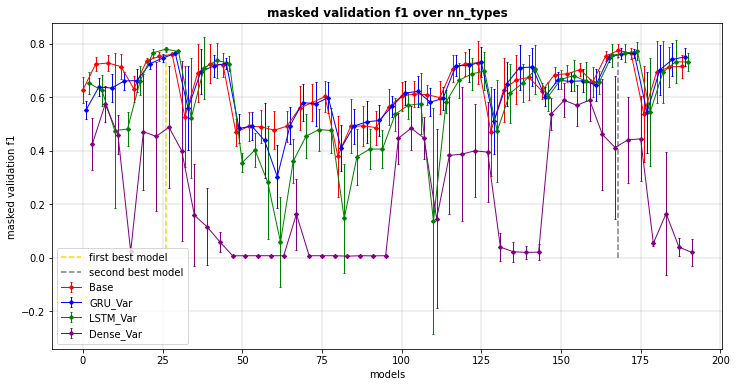

In [ ]:
# summarize history for trining accuracy
plot_across_models(df_res_config, param_grid['nn_type'], fbm=best_model_index, 
                   sbm=second_best_model_index, metric='masked validation f1')

We can observe that the Base architecture and LSTM variation are those which reach the highest mean value of masked validation F1 (in accordance with the two best model parameters).

The Dense generally seems to be the worst one, usually also with quite high variance.

We can also notice that LSTM variation reaches the highest mean value, but generally seems to work a little worse than Base and the GRU variation, which give comparable results.

-------

The following function plots the metrics for all tested architectures considering only one parameter at a time: fixing a specific metric and a specific parameter, the value of a point is the mean of the metric values obtained changing all other parameters. We are aware that this metric is approximated (due to the elements of the mean not being independent), but we can still obtain some information about the best values for each parameter. With those plots we can check if the parameter values of the best model and the second best model are due to random factors or if they are actually values that increase performances.

In [ ]:
# plot metrics for all tested architectures considering only one parameter at a time
def plot_avgs(df, param_grid, fbm=None, sbm=None, legend_pos='lower left',
                       figsize=(18,6), metric='masked validation f1'):
    nn_types = param_grid['nn_type']
    # save only parameters with more than one tested value
    param_grid = {k: v  for k,v in param_grid.items() if len(v)>1 if k!='nn_type'}
    colors = ['red', 'blue', 'green', 'purple']
    nrows = len(param_grid)
    figsize = figsize[0], figsize[1]*nrows
    fig, axs = plt.subplots(nrows=nrows, ncols=1, sharex=False, figsize=figsize)
    
    y = {}
    c = 0
    for par in param_grid:
        assert c<len(axs)
        x = param_grid[par]        
        
        for nn_idx in range(len(nn_types)):
            y = []
            yerr = []
            for val in x:
                y_vals = df[df['nn_type'] == nn_types[nn_idx]][df[par] == val][metric].to_numpy()
                y_stds = df[df['nn_type'] == nn_types[nn_idx]][df[par] == val][metric+' std'].to_numpy()
                y.append(np.mean(y_vals))
                yerr.append(np.mean(y_stds))
            
            # assuming standard error (SE)
            # mean +/- 1*std => 68.2% of vals
            # mean +/- 2*std => 95.4% of vals
            # mean +/- 3*std => 99.6% of vals
            std_mult = 2
            x_range = max(x) - min(x)
            # check the correct order of plotting
            x.sort()
            # 5% of edges
            axs[c].set_xlim([-0.05*x_range,max(x)+0.05*x_range])
            plt.sca(axs[c])
            if par == 'regularizer_weight':
                plt.xticks(x, ['0'] + ['{0:.1e}'.format(x[i]) for i in range(1,len(x))], rotation = 90)
            else:
                plt.xticks(x, rotation = 90)
            axs[c].errorbar(x = x,
                            y = y,
                            yerr = [e*std_mult for e in yerr],
                            color = colors[nn_idx],
                            linestyle = '-',
                            linewidth = 1,
                            marker = 'D',
                            markersize = 3.,
                            capsize = 5)

        axs[c].set_ylabel(metric)
        axs[c].set_xlabel(par)
        axs[c].legend(nn_types, loc=legend_pos)
        axs[c].grid(color='gray', linestyle='-', linewidth=0.25)

        c += 1

**Best Model parameters**
    
    nn_type            - LSTM_Var,
    nodes              - 64,
    lr                 - 0.01,
    regularizer_weight - 0

**Second Best Model parameters**
    
    nn_type            - Base,
    nodes              - 64,
    lr                 - 0.01,
    regularizer_weight - 1e-05

**Possible Metric Arguments**
    
    "training accuracy", "validation accuracy", "training loss", "validation loss", "masked validation accuracy", "masked validation f1"

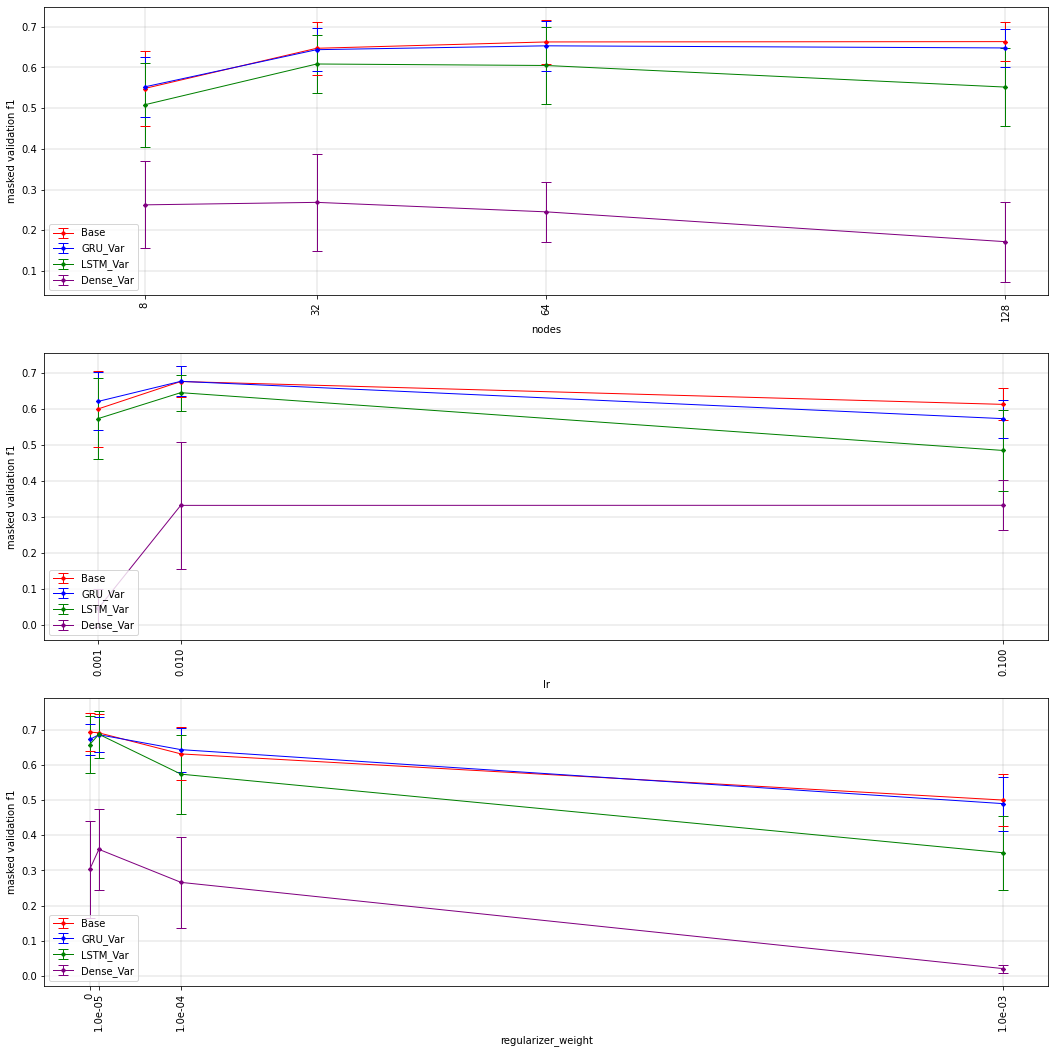

In [ ]:
plot_avgs(df_res_config, param_grid, fbm=best_model_index, 
          sbm=second_best_model_index, metric='masked validation f1')

These plots highlight how the different architectures follow almost always the same trend, with a specific value which usually gives the best performances for all.

From the first plot we can see that the best number of nodes for our layers is around 32 and 64 (64 is the number of the best and the second best model). For the Base and the GRU variant architecture, 32 and 64 and 128 give comparable results, while in the other cases 128 seems to be a too high value.

From the second plot we have that clearly lr=0.01 is the best choice among the tested values.

The last plot confirms that the two best values for the regularizer weight are 0 and 1e-5 (the values we have with the two best models).

As already seen in the previous plot the Base and the GRU variant architectures seem to be the best ones (among those we have tested), with the LSTM variants which performs slightly worse and the Dense ones which are definitely the worst. This lets us suppose that, with more data or a different dataset, the LSTM variant may no longer be the best architecture.

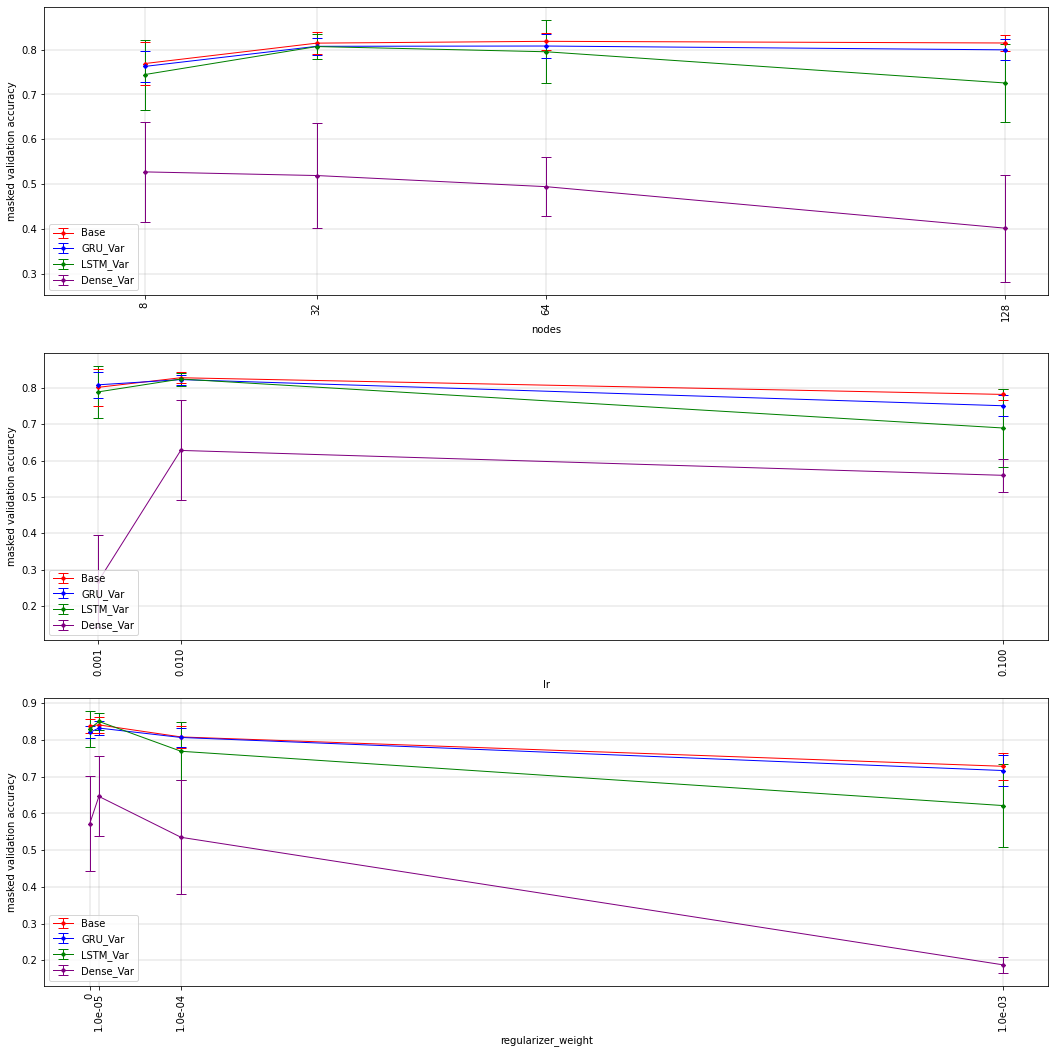

In [ ]:
plot_avgs(df_res_config, param_grid, fbm=best_model_index, 
          sbm=second_best_model_index, metric='masked validation accuracy')

Accuracy also confirms all our hypotheses.

----

The previous plots are mean values of the specified metric. With the following histograms we can focus on each of those points and understand the origin of the mean values and the corresponding standard deviations.

In [ ]:
def plot_models_hist(df, param_grid, legend_pos='lower left',
                     figsize=(18,12), metric='training accuracy',
                     subplot_col='regularizer_weight'):
  

    #section_col = 'nn_type'
    subplot_unique_values = param_grid[subplot_col]
    section_unique_values = param_grid['nn_type']
    
    param_grid = {k: v  for k,v in param_grid.items() if len(v)>1 and k!='nn_type' and k!=subplot_col}

    nplots = len(subplot_unique_values)
    nsections = len(section_unique_values)

    figsize=(figsize[0],figsize[1]*nplots)

    fig, axs = plt.subplots(nplots, 1, figsize=figsize)
    colors = ['red','blue','green','purple']

    for plt_it in range(0,nplots):
        df1 = []
        df_subplot = df[df[subplot_col] == subplot_unique_values[plt_it]]
        for i in range(nsections):
            tmp = df_subplot[df_subplot['nn_type'] == section_unique_values[i]]
            df1.append(tmp[metric].to_numpy())
          
        df1 = pd.DataFrame(data=np.transpose(df1), columns= ['nn_type='+s for s in section_unique_values])
        df1.plot.bar(figsize=figsize, ax=axs[plt_it], color=colors)

        df_section = df_subplot[df_subplot['nn_type'] == section_unique_values[0]]
        
        x_labels = []
        
        for j in range(len(df_section)):
          s = ''
          for par in param_grid:
            s += par + '=' + str(df_section.iloc[j][par]) + '\n'
          x_labels.append(s)



        axs[plt_it].set_xticklabels(x_labels, rotation=45)
        
        title = 'Mean ' + metric + ' in ' + subplot_col + '=' + str(subplot_unique_values[plt_it])
        axs[plt_it].set_title(title, fontweight="bold")
        axs[plt_it].set_ylabel(metric)
        axs[plt_it].set_xlabel('configurations')
        axs[plt_it].legend(loc=legend_pos)
        axs[plt_it].grid(color='gray', linestyle='-', linewidth=0.25)
    plt.show()

**Possible Metric Arguments**

    "training accuracy", "validation accuracy", "training loss", "validation loss", "masked validation accuracy", "masked validation f1"

**Possible *subplot_col* arguments**

    "regularizer_weight", "lr", "nodes"

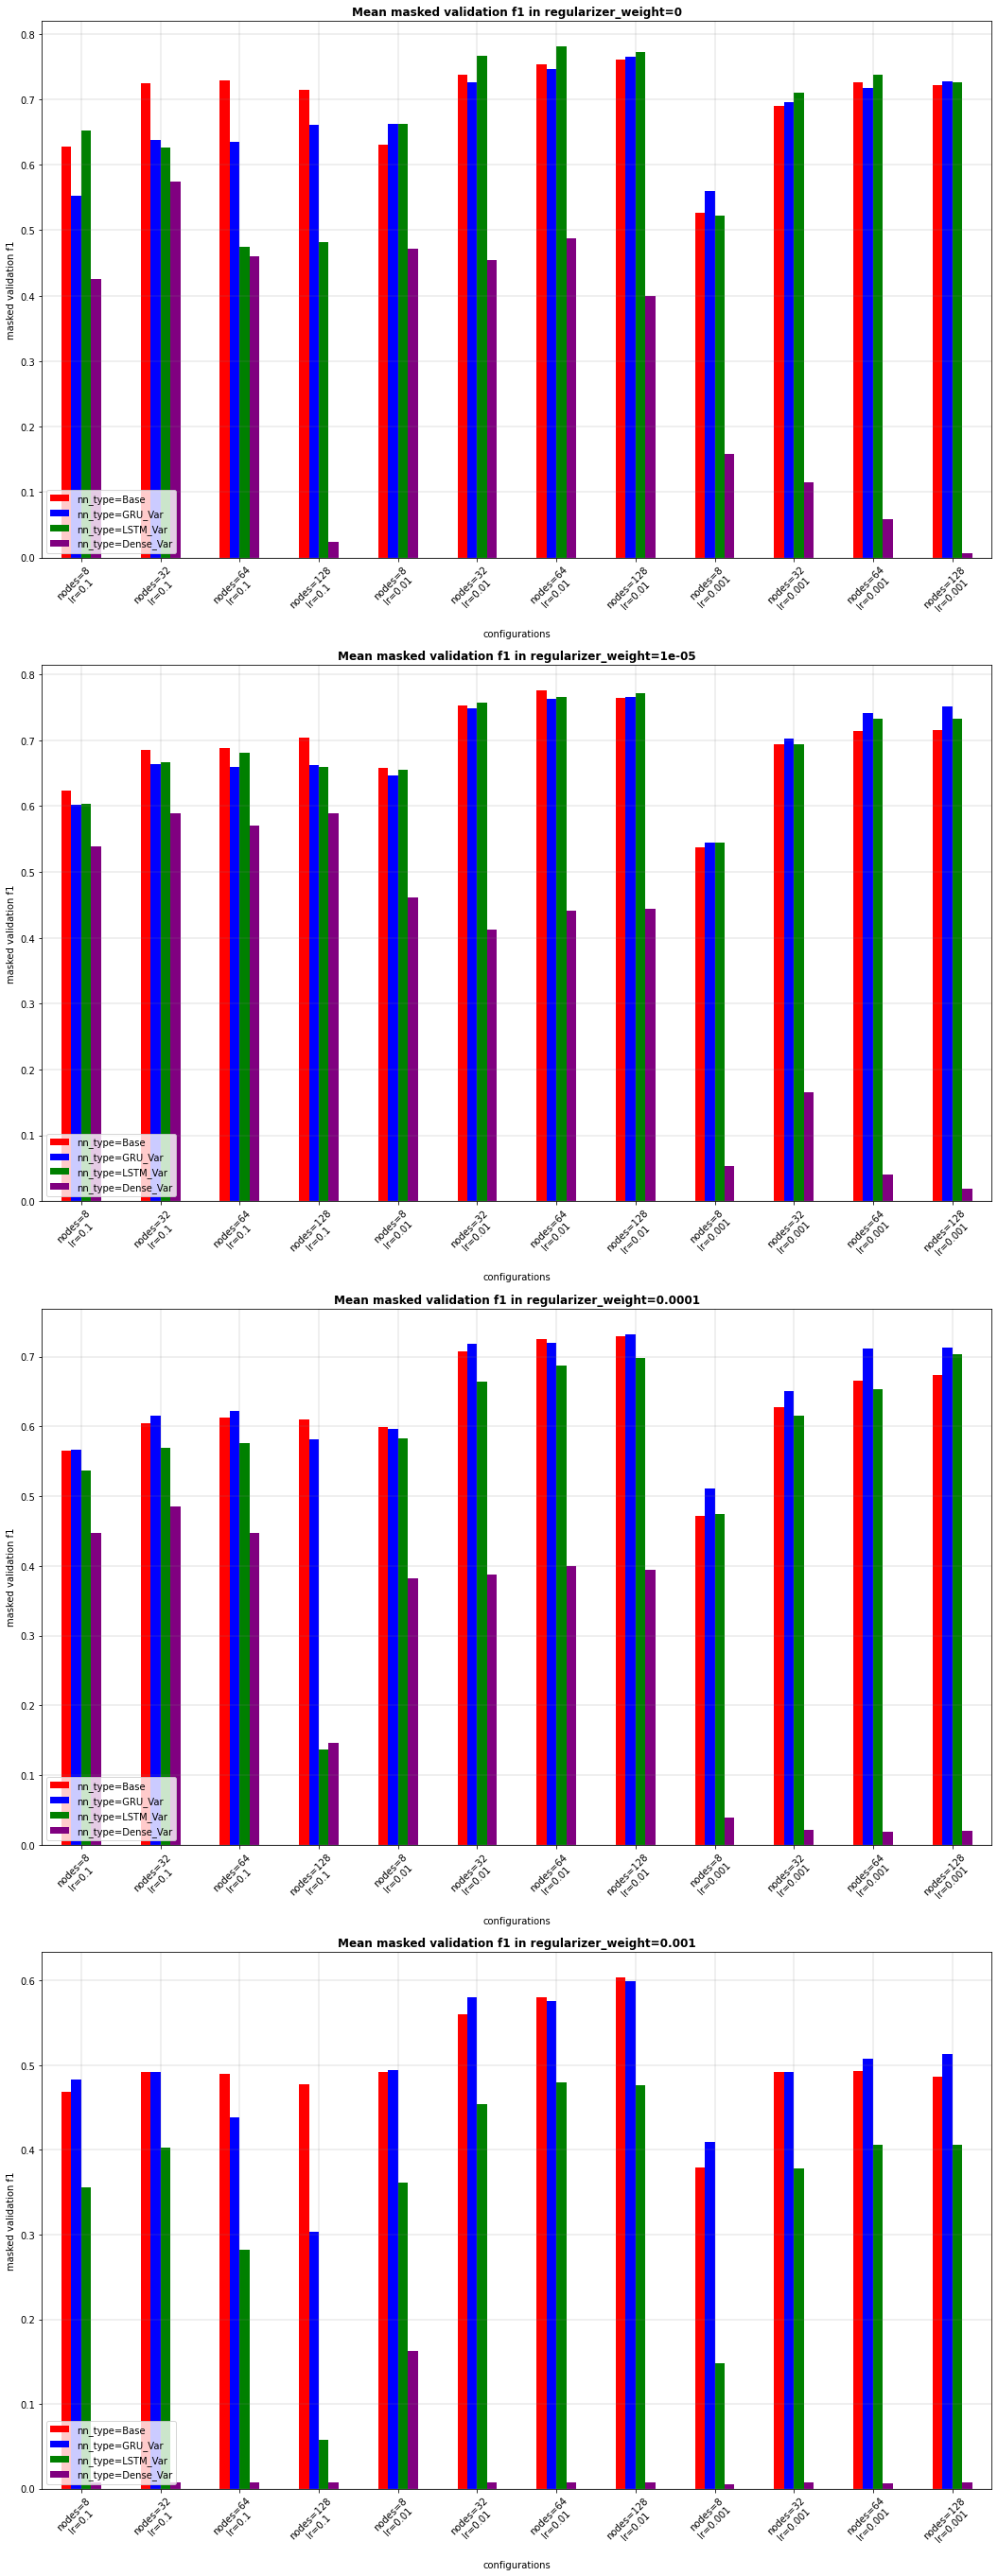

In [ ]:
plot_models_hist(df_res_config,
                 param_grid, 
                 metric='masked validation f1',
                 subplot_col='regularizer_weight')

These histograms confirm what we have seen before, but here we can focus more on the variance of different architectures: as usual Base and GRU variants behave similarly, but the LSTM variant has a higher decrease in F1 score with higher value of the regularizer weight. We can also notice a general high variation on performances of the Dense variant architecture.

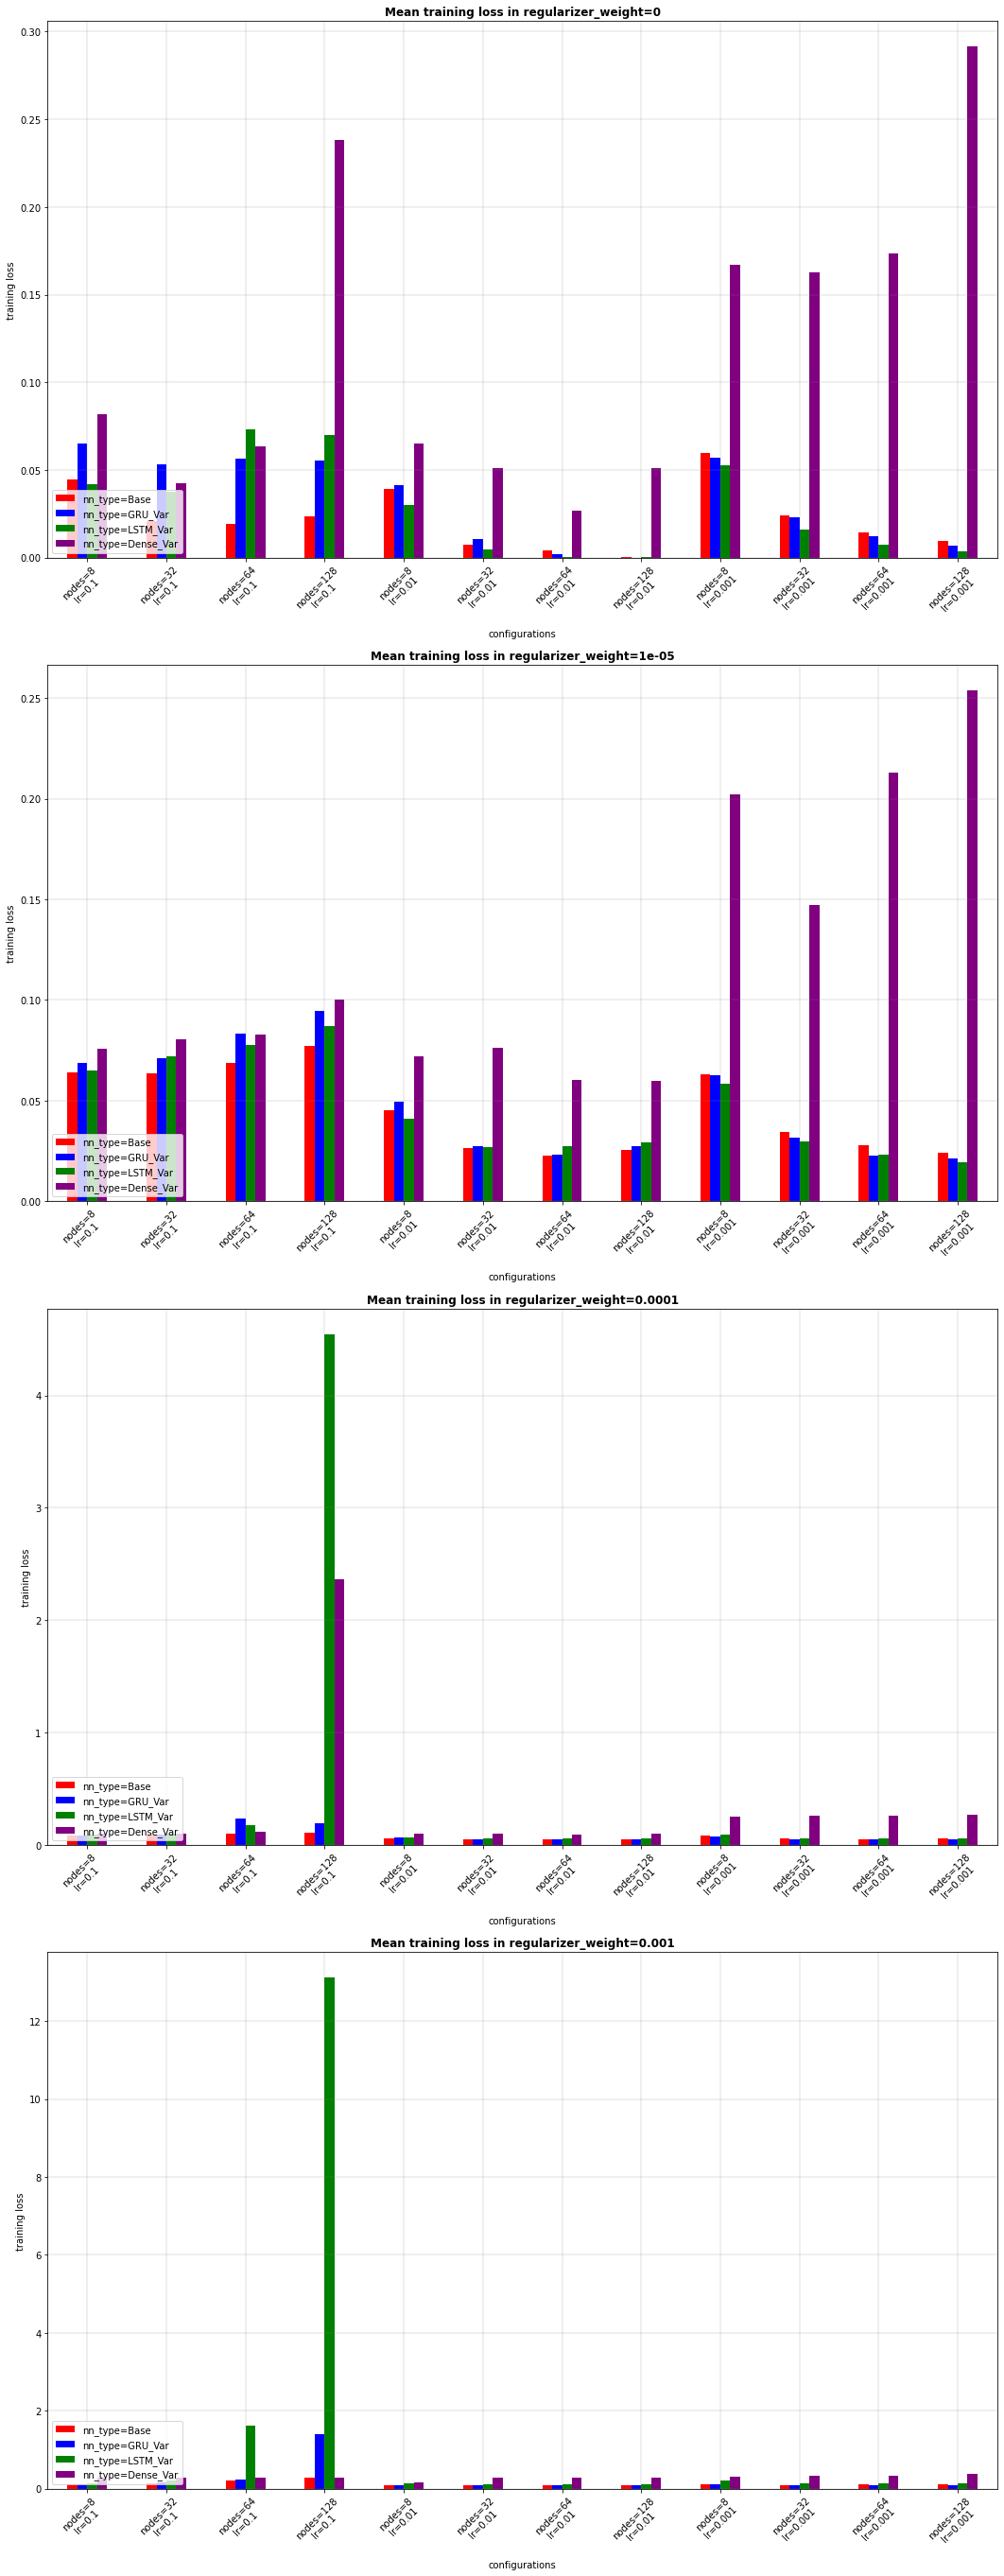

In [ ]:
plot_models_hist(df_res_config, 
                 param_grid,
                 metric='training loss',
                 subplot_col='regularizer_weight')

The histograms about the training loss show an interesting and high value for a few specific models. 

    {'nn_type': 'LSTM_Var', 'nodes': 128, 'activation': 'softmax', 'loss': 'categorical_crossentropy', 'lr': 0.1, 'regularizer_weight': 0.0001},

    {'nn_type': 'LSTM_Var', 'nodes': 128, 'activation': 'softmax', 'loss': 'categorical_crossentropy', 'lr': 0.1, 'regularizer_weight': 0.001}

In the following cell we explicitly computed the loss for the last one.

In [ ]:
a = np.array(params)
bad_idx = np.where(a=={'nn_type': 'LSTM_Var', 'nodes': 128, 'activation': 'softmax', 'loss': 'categorical_crossentropy', 'lr': 0.1, 'regularizer_weight': 0.001})
bad_idx = bad_idx[0][0]
bad_train_loss = train_history[bad_idx]['training loss']
print('bad training loss',
      '\nmean:\t {:.2f}'.format(np.mean(bad_train_loss)),
      '\nstd:\t {:.2f}'.format(np.std(bad_train_loss)))

bad training loss 
mean:	 13.11 
std:	 10.19


------

The following plots compare the different keras metrics of the two best models, epoch by epoch.

The first best model, is identified by the `gold` color instead of the `gray` for the second best model.

In [ ]:
def plot_firstVSsecond_best_model(FBhist, SBhist, 
                                  legend_pos='upper right',
                                  figsize=(12,6), metric='training accuracy'):
    plt.figure(figsize=figsize)
    plt.plot(FBhist[metric], label='first best model',
            color='gold', marker='o', linestyle='-', linewidth=1)
    plt.plot(SBhist[metric], label='second best model',
            color='gray', marker='^', linestyle='-', linewidth=1)
    title = metric + ' two best models'
    plt.title(title, fontweight="bold")
    plt.ylabel(metric)
    plt.xlabel('epochs')
    plt.legend(loc=legend_pos)
    plt.grid(color='gray', linestyle='-', linewidth=0.25)
    plt.show()

**Possible Metric Arguments**

    "categorical_accuracy", "val_categorical_accuracy", "loss", "val_loss"

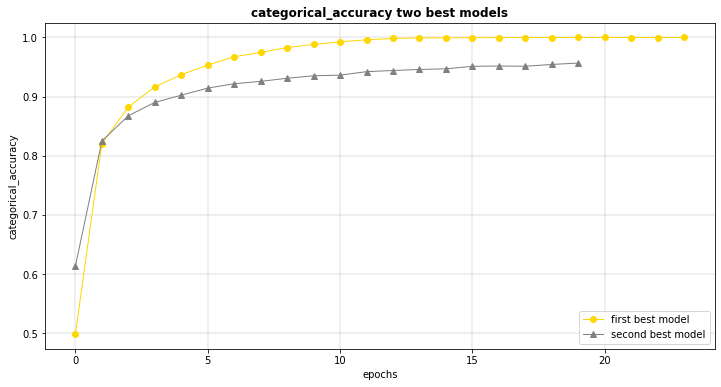

In [ ]:
plot_firstVSsecond_best_model(best_train_history, second_train_history, 
                              metric='categorical_accuracy',
                              legend_pos='lower right')

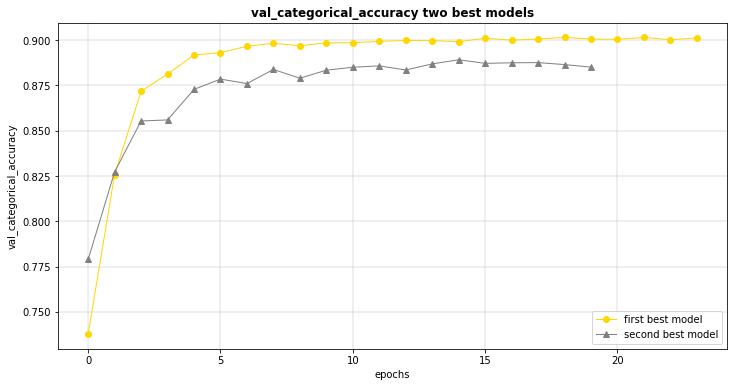

In [ ]:
plot_firstVSsecond_best_model(best_train_history, second_train_history, 
                              metric='val_categorical_accuracy',
                              legend_pos='lower right')

From the plots we can deduce that the best model did not need so many epochs to fit properly.

The other main consideration is that increasing the patience value for the testing helped the second best model to reach higher accuracy.

------

This function plots an histogram of final accuracy of the two best model. This is done to have a better comparison between them.

In [ ]:
def plot_firstVSsecond_best_model_hist(FBhist, SBhist, FBtestmtric, SBtestmetric,
                                  legend_pos='upper right',
                                  figsize=(16,12)):
    colors = ['gold', 'gray']

    ax = pd.DataFrame({'first best model': [FBhist['categorical_accuracy'][-1],
                                            FBhist['val_categorical_accuracy'][-1],
                                            FBtestmtric['accuracy']
                                            ],
                       'second best model': [SBhist['categorical_accuracy'][-1],
                                             SBhist['val_categorical_accuracy'][-1],
                                             SBtestmetric['accuracy']
                                            ]})\
            .plot.bar(label=['first best model', 'second best model'], color=colors,
                      figsize=figsize)

    ax.set_xticklabels(['training accuracy', 'validation accuracy', 'test accuracy'], rotation=0)
    
    rects = ax.patches
    labels = np.round([FBhist['categorical_accuracy'][-1], 
                       FBhist['val_categorical_accuracy'][-1],
                       FBtestmtric['accuracy'], 
                       SBhist['categorical_accuracy'][-1], 
                       SBhist['val_categorical_accuracy'][-1],
                       SBtestmetric['accuracy']
                       ], 3)
    
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2, height+0.01, label,
                ha='center', va='bottom')

    plt.title('First best model VS Second best model', fontweight="bold")
    plt.ylabel('score')
    plt.legend(loc=legend_pos)
    plt.grid(color='gray', linestyle='-', linewidth=0.25)
    plt.show()

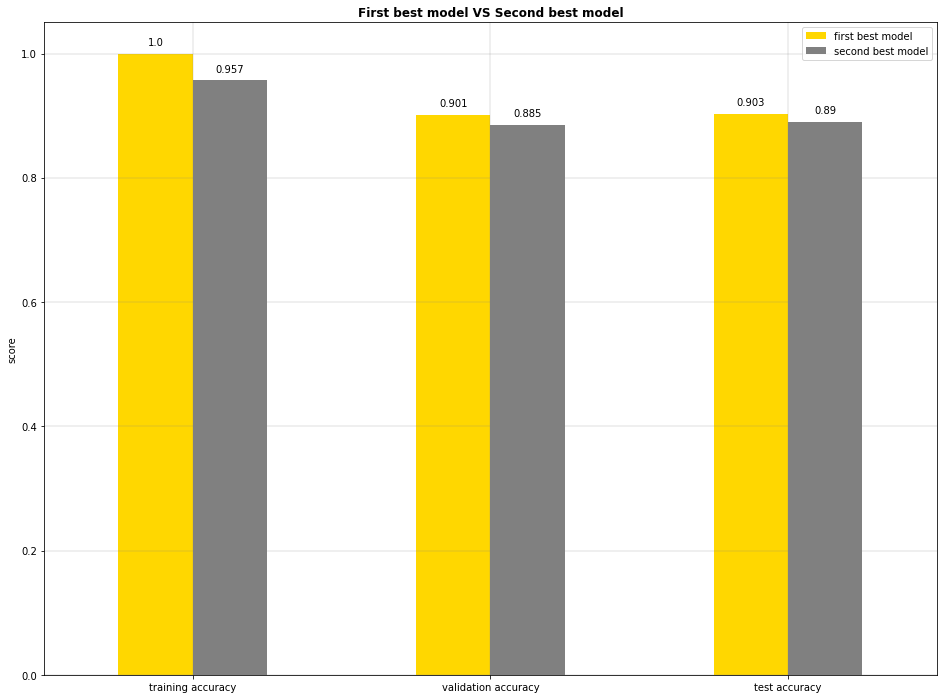

In [ ]:
plot_firstVSsecond_best_model_hist(best_train_history, second_train_history, 
                            best_model_metrics, second_best_model_metrics,
                            legend_pos='upper right')

As we can see, we got very good results in the both of the two best models. Moreover the results seem to be consistent between training, validation and test set. Scores are also coherent between test and validation sets, as they are within 5% of each other for our best models, and are actually better on the test set.  This is likely due to the unbalancednature of the dataset:  indeed, accuracy is about 10% higher than F1-score, further supporting this claim.

------

Finally, we plot confusion matrices to inspect how the best model behaves with respect to the different classes.

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
tags_unique = df_without_sym.groupby('tag').agg('count').index[:].tolist()

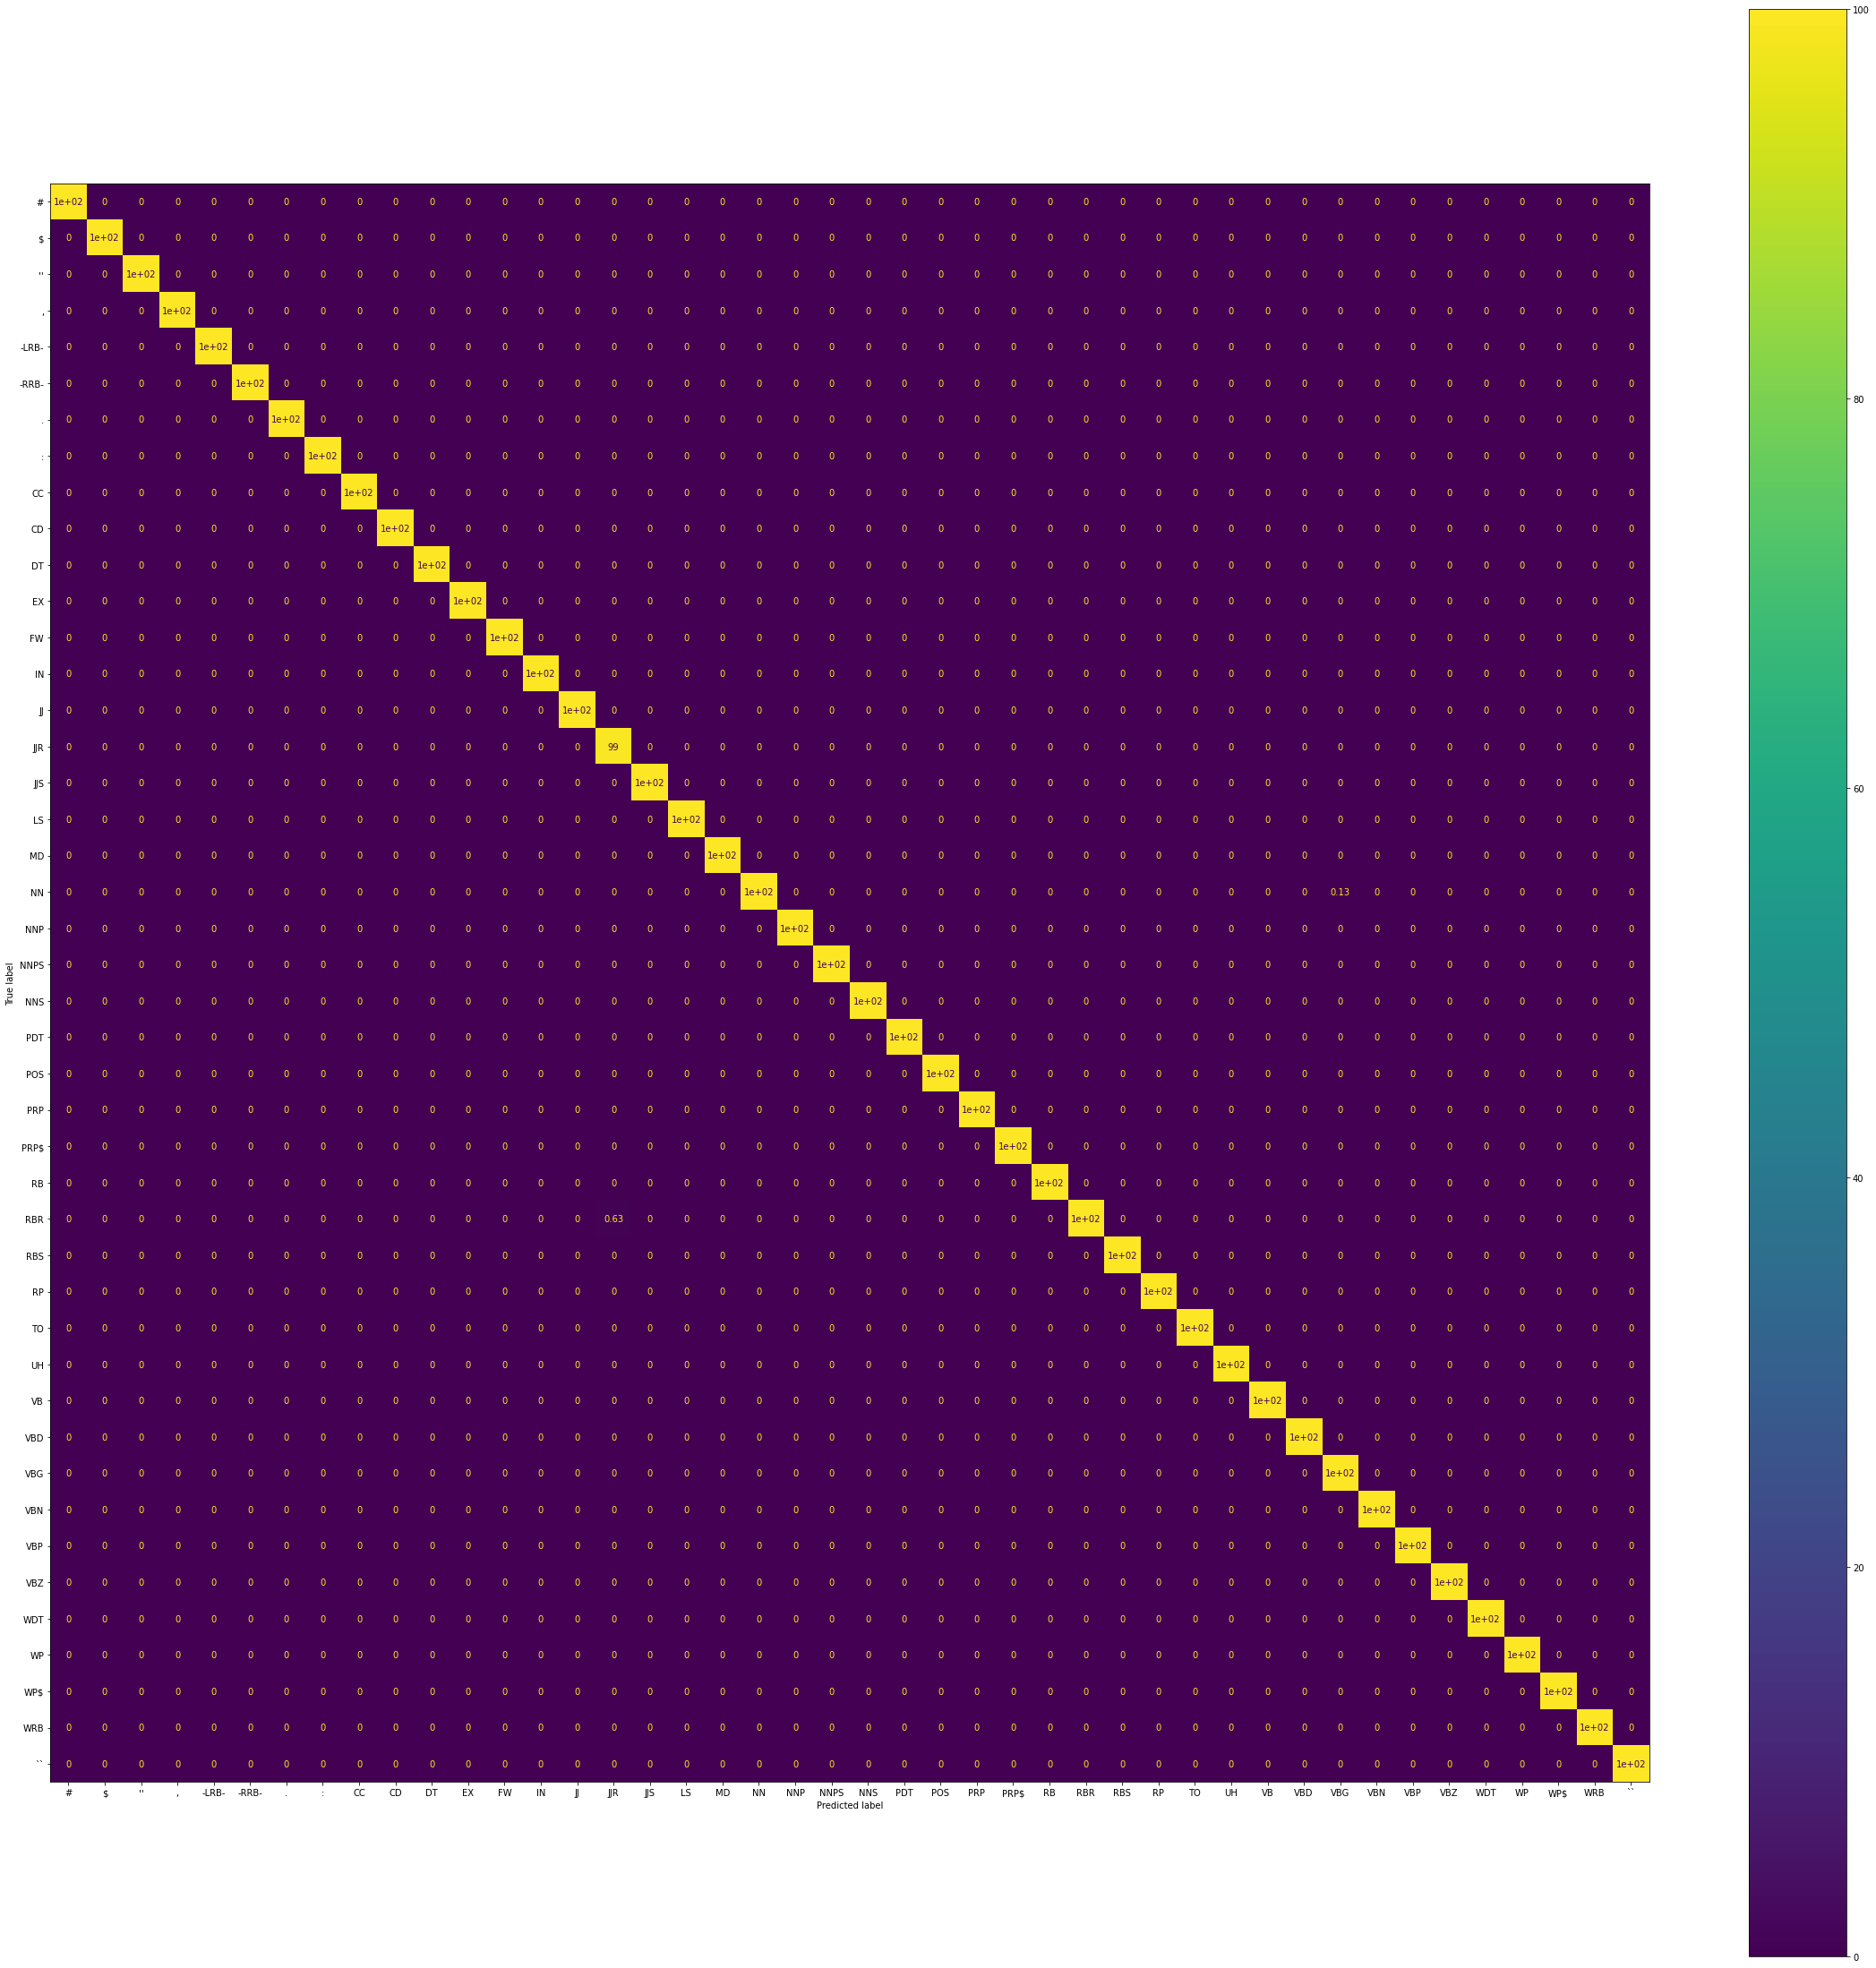

In [ ]:
# Training set
predictions = best_model.predict(X_train)
y_true_index, y_pred_index, true_class_labels, sample_weights = post_processing(y_train, predictions)
fig, ax=plt.subplots(1,1,figsize=(40,40))
cm = confusion_matrix(y_true_index, y_pred_index, normalize='pred')
cm = np.round(cm*100, 2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=tags_unique)
disp.plot(ax=ax)
plt.show()

This first confusion matrix confirms that the training accuracy is of 100%.

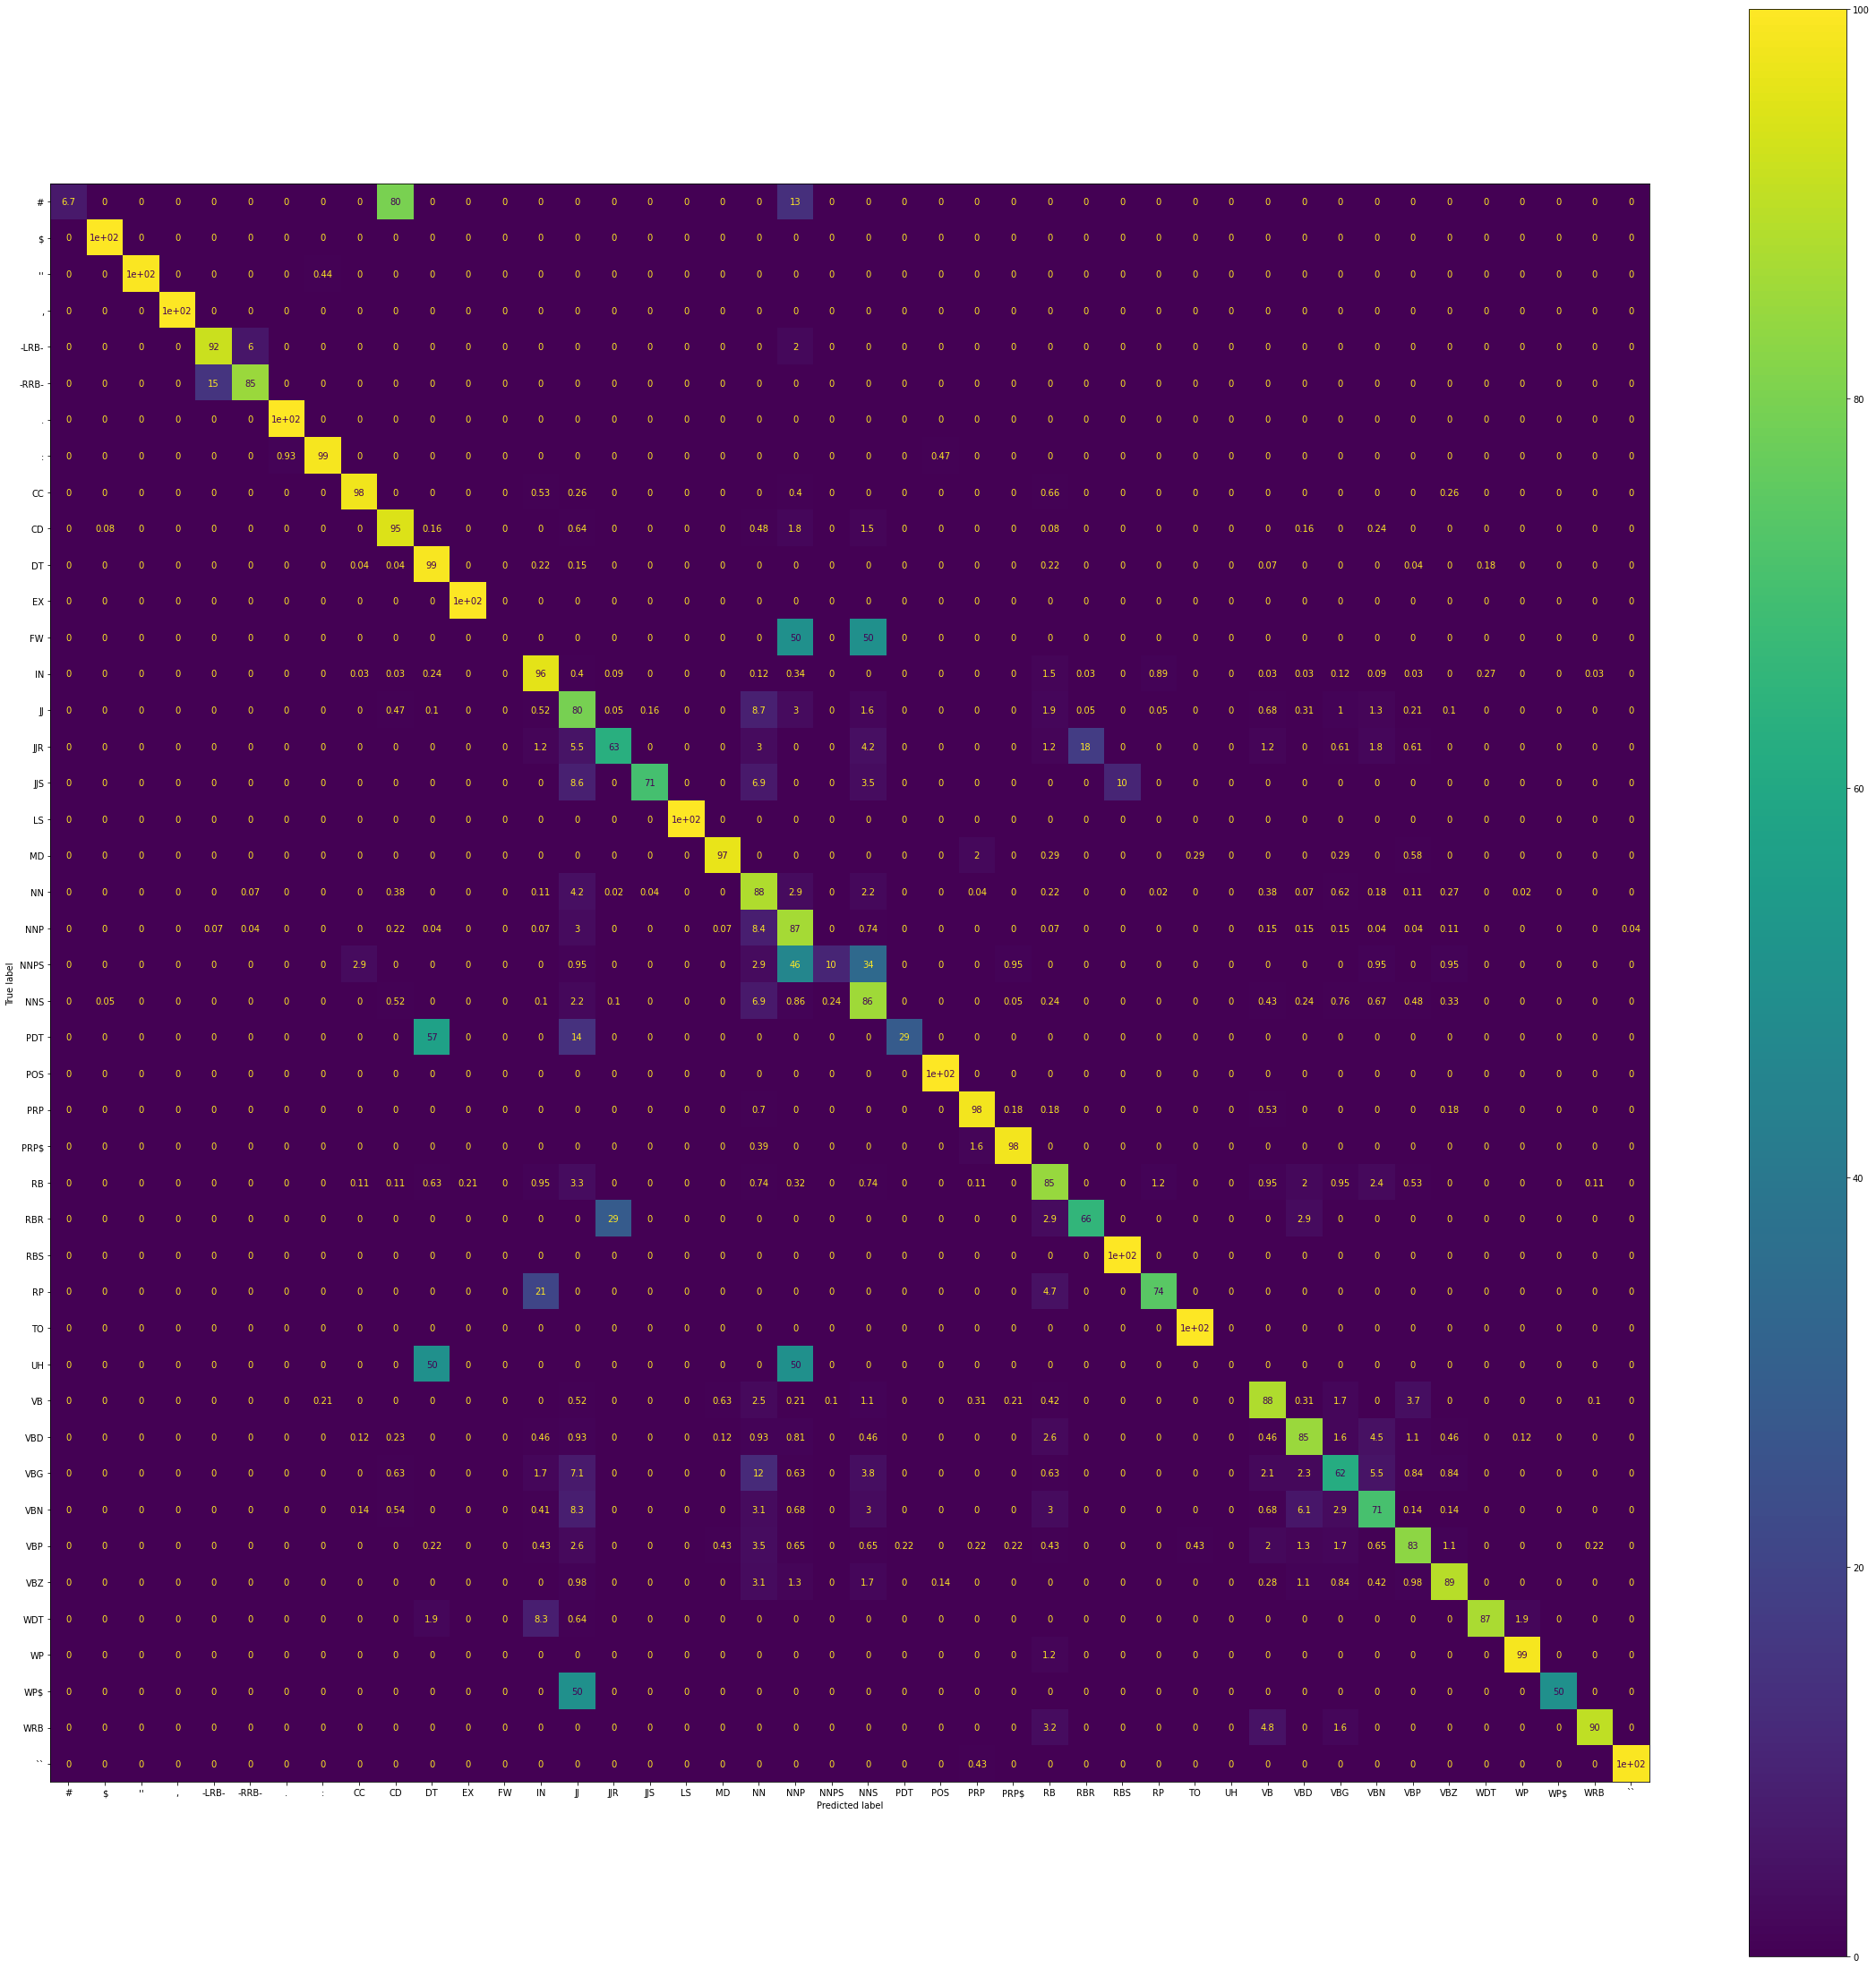

In [ ]:
# Val set
predictions = best_model.predict(X_val)
y_true_index, y_pred_index, true_class_labels, sample_weights = post_processing(y_val, predictions)
fig, ax=plt.subplots(1,1,figsize=(40,40))
cm = confusion_matrix(y_true_index, y_pred_index, normalize='true')
cm = np.round(cm*100, 2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[tags_unique[id] for id in np.unique(y_true_index)])
disp.plot(ax=ax)
plt.show()

**FW** and **UH** are never predicted correctly in the validation set, again due to the small number of instances in the train set. Infrequent classes such as **RB**, **RP**, **WP$** under-perform and **NNPS** also does, most likely due to not using case sensitivity. As a positive note, we do see clustering of guesses among similar tags, such as different noun or verb types. 

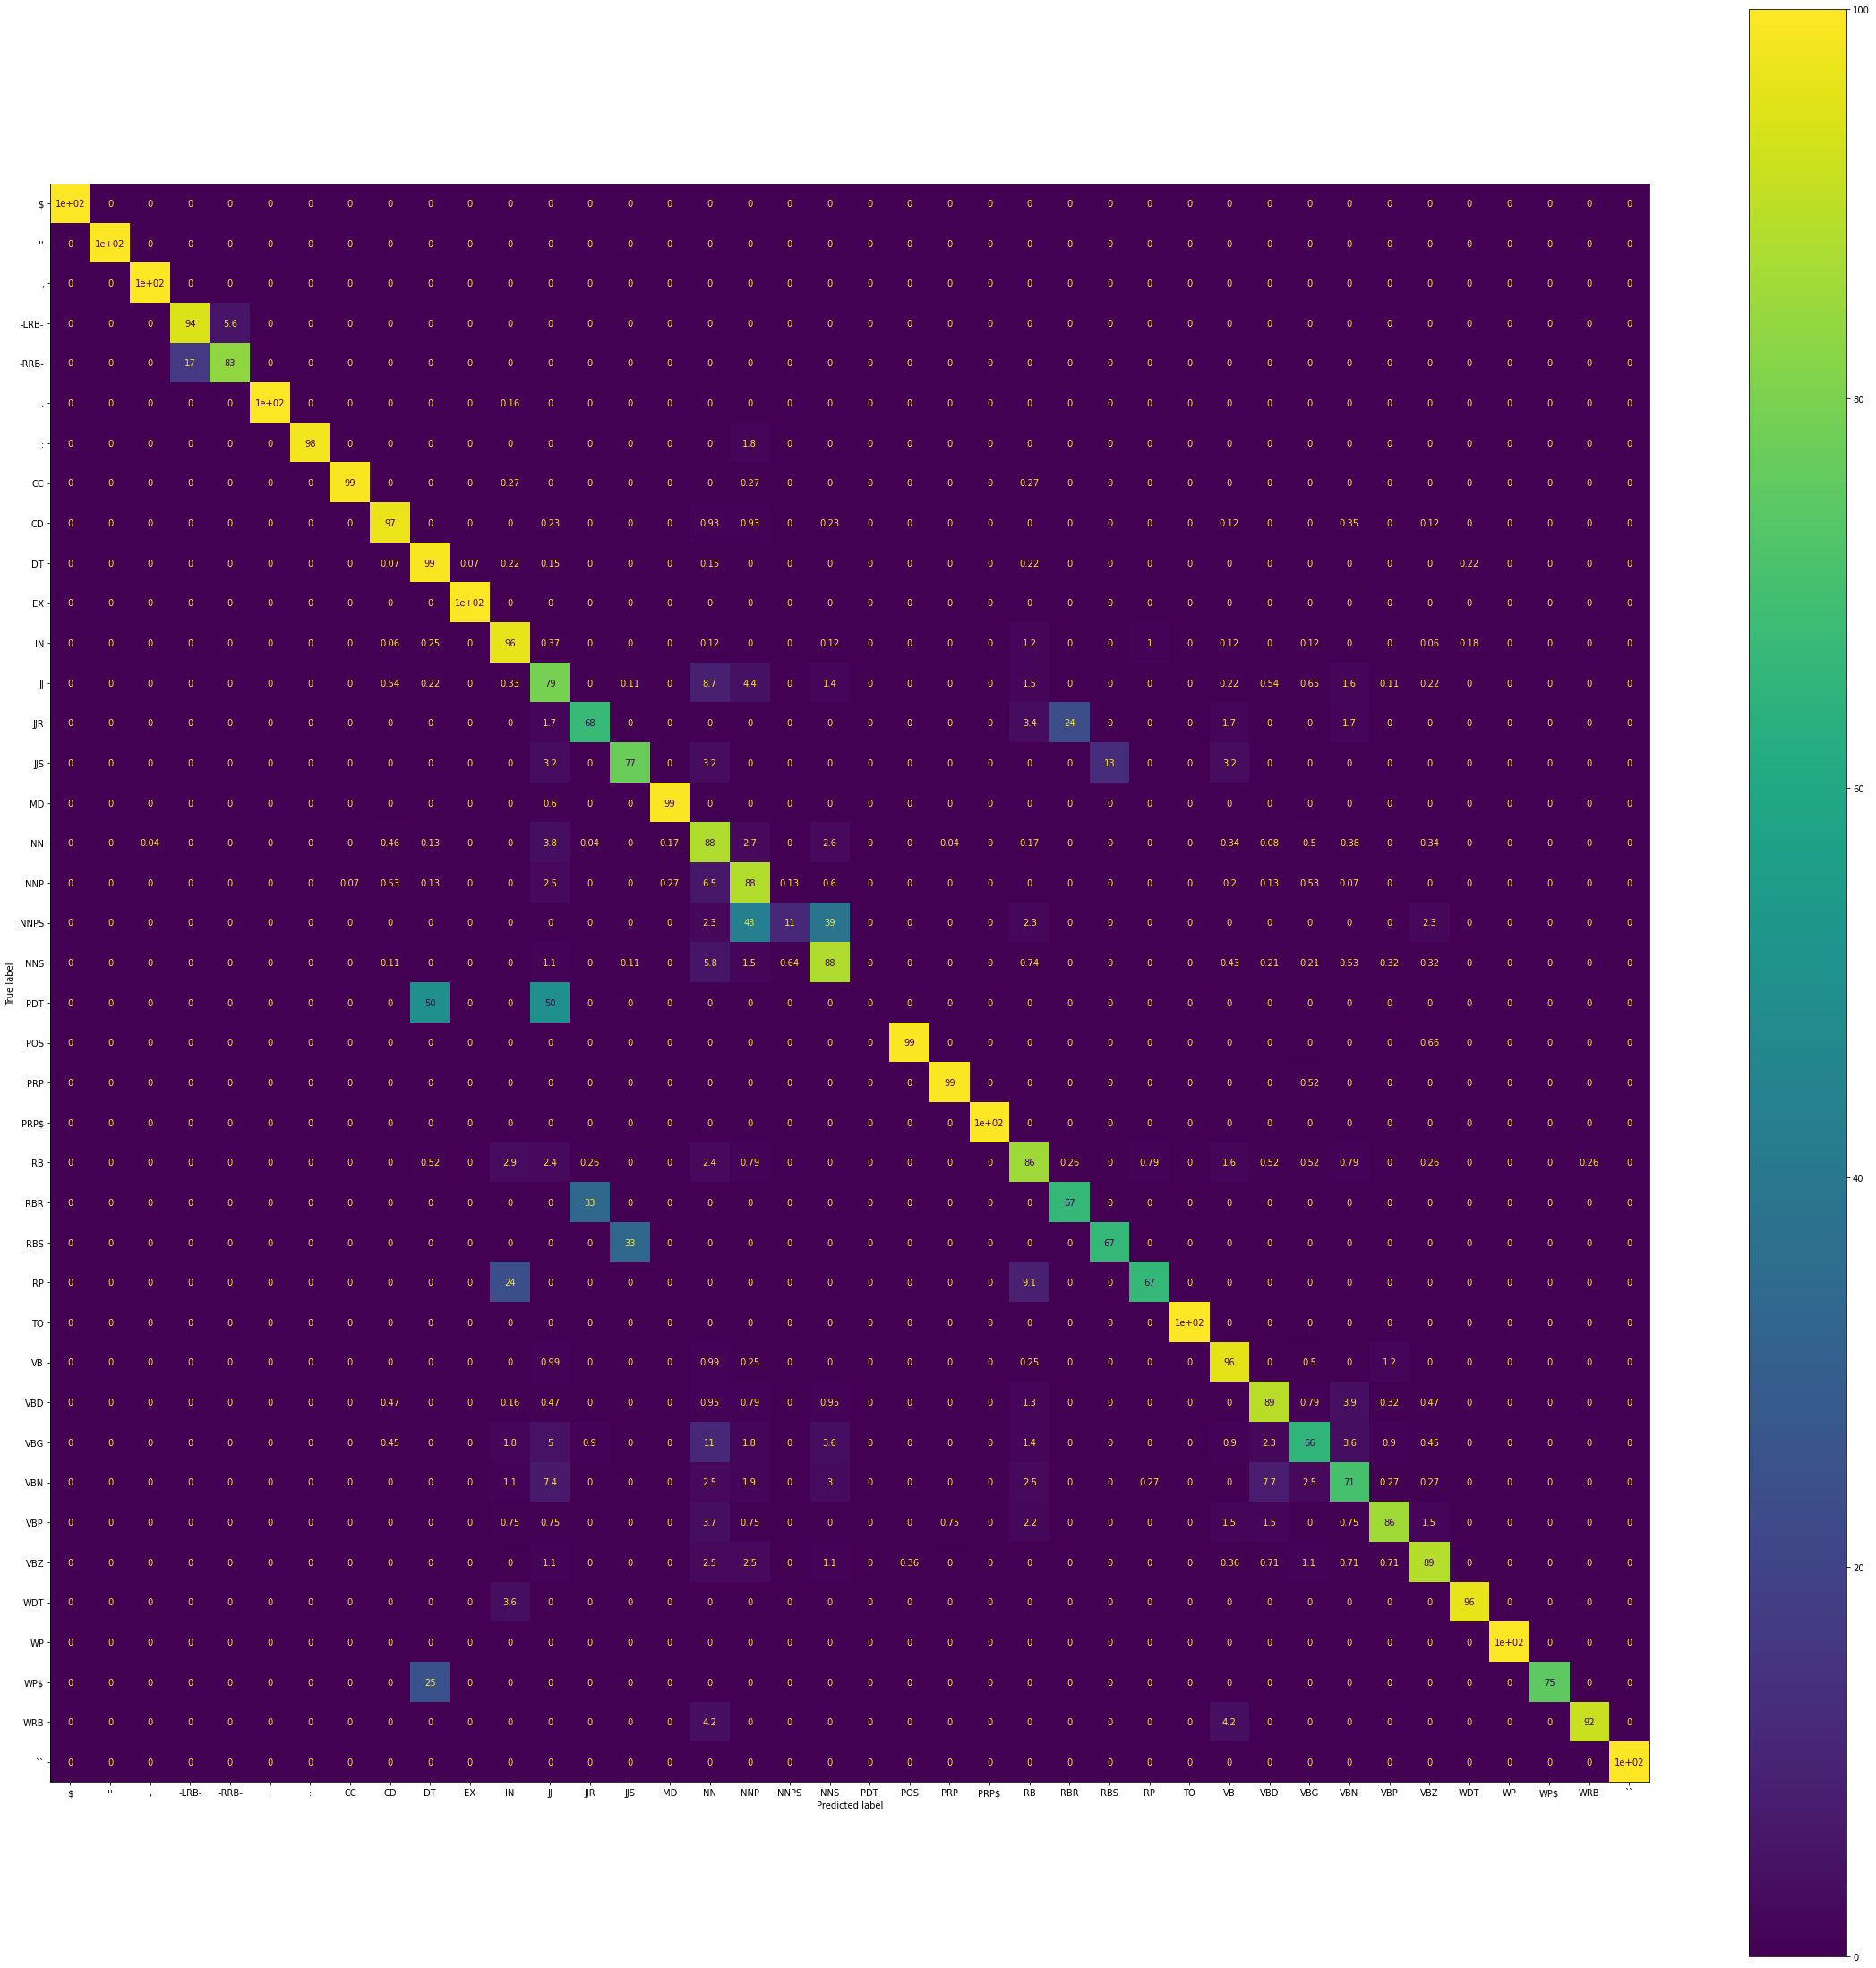

In [ ]:
# Test set
predictions = best_model.predict(X_test)
y_true_index, y_pred_index, true_class_labels, sample_weights = post_processing(y_test, predictions)
fig, ax=plt.subplots(1,1,figsize=(40,40))
cm = confusion_matrix(y_true_index, y_pred_index, normalize='true')
cm = np.round(cm*100, 2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[tags_unique[id] for id in np.unique(y_true_index)])
disp.plot(ax=ax)
plt.show()

The test confusion matrix is coherent with the validation one. A few classes are missing, due to them not being present at all in the test set.